# CMS GIWAXS plotting notebook - plotting single images from loaded zarr datasets
# PM6 Y6-series solvent study GIWAXS CMS 2023C3

## Imports

In [1]:
# Imports:
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import xarray as xr
from tqdm.auto import tqdm

# Choose a colormap:
cmap = plt.cm.turbo
cmap.set_bad('black')

## Define & check paths

In [2]:
def select_attrs(data_arrays_iterable, selected_attrs_dict):
    """
    Selects data arrays whose attributes match the specified values.

    Parameters:
    data_arrays_iterable: Iterable of xarray.DataArray objects.
    selected_attrs_dict: Dictionary where keys are attribute names and 
                         values are the attributes' desired values.

    Returns:
    List of xarray.DataArray objects that match the specified attributes.
    """    
    sublist = list(data_arrays_iterable)
    
    for attr_name, attr_values in selected_attrs_dict.items():
        sublist = [da.copy() for da in sublist if da.attrs[attr_name] in attr_values]
                
    return sublist

def fold_image(data_array, fold_axis, progress_bar=False):
    """
    Method to fold image along a specified axis.
    
    Parameters:
    - data_array (xarray DataArray): The DataArray to fold
    - fold_axis (str): The axis along which to fold the image
    
    Returns:
    - xarray DataArray: The folded image
    """
    # Filter data for fold_axis >= 0 and fold_axis <= 0
    positive_data = data_array.where(data_array[fold_axis] >= 0, drop=True)
    negative_data = data_array.where(data_array[fold_axis] <= 0, drop=True)
    
    # Reverse negative_data for easier comparison
    negative_data = negative_data.reindex({fold_axis: negative_data[fold_axis][::-1]})
    
    # Find the maximum coordinate of the shorter quadrant (positive_data)
    max_positive_coord = float(positive_data[fold_axis].max())
    
    # Find the equivalent coordinate in the negative_data
    abs_diff = np.abs(negative_data[fold_axis].values + max_positive_coord)
    
    # Minimize the difference
    min_diff_idx = np.argmin(abs_diff)
    
    # Check if the lengths are equivalent
    len_pos = len(positive_data[fold_axis])
    len_neg = len(negative_data[fold_axis][:min_diff_idx+1])
    
    if len_pos != len_neg:
        # Adjust the coordinate range for negative_data
        for i in range(1, 4):  # Check 3 neighbors
            new_idx = min_diff_idx + i
            len_neg = len(negative_data[fold_axis][:new_idx+1])
            if len_pos == len_neg:
                min_diff_idx = new_idx
                break
                
    # Crop the negative_data to match positive_data length
    negative_data_cropped = negative_data.isel({fold_axis: slice(0, min_diff_idx+1)})
    
    # Prepare the new data array
    new_data = xr.zeros_like(positive_data)
    
    # Fold the image
    if progress_bar:
        for i in tqdm(range(len(positive_data[fold_axis]))):
            pos_val = positive_data.isel({fold_axis: i}).values
            neg_val = negative_data_cropped.isel({fold_axis: i}).values

            # Pixel comparison and choosing 
            new_data[i] = np.where(((pos_val == 0) | (np.isnan(pos_val))) & (neg_val > 1-1e-6),
                                   neg_val, 
                                   pos_val)
    else:
        for i in range(len(positive_data[fold_axis])):
            pos_val = positive_data.isel({fold_axis: i}).values
            neg_val = negative_data_cropped.isel({fold_axis: i}).values

            # Pixel comparison and choosing 
            new_data[i] = np.where(((pos_val == 0) | (np.isnan(pos_val)) | (pos_val < 2)) & (neg_val > 0.001),
                                   neg_val, 
                                   pos_val) 
            
            # # Pixel comparison and averaging
            # new_data[i] = np.where(
            #     (pos_val > 0) & (neg_val > 0), 
            #     (pos_val + neg_val) / 2,
            #     np.where(((pos_val == 0) | (np.isnan(pos_val))) & (neg_val > 0),
            #              neg_val, 
            #              pos_val)
            # )


        
    # Append residual data from the longer quadrant if exists
    if len(negative_data[fold_axis]) > min_diff_idx+1:
        residual_data = negative_data.isel({fold_axis: slice(min_diff_idx+1, None)})
        residual_data[fold_axis] = np.abs(residual_data[fold_axis])
        new_data = xr.concat([new_data, residual_data], dim=fold_axis)
        
    # Update data_array with the folded image
    data_array = new_data.sortby(fold_axis)
    
    # Inherit coordinates and metadata attributes from the original data_array
    data_array.attrs = data_array.attrs.copy()
    data_array.attrs['fold_axis'] = fold_axis  # Add 'fold_axis' attribute

    # Ensure all original coordinates are retained in the new data_array
    for coord in data_array.coords:
        if coord not in data_array.coords:
            data_array = data_array.assign_coords({coord: data_array[coord]})

    return data_array

In [3]:
# I like pathlib for its readability & checkability, it's also necessary for the loadSeries function later on
# Replace the paths with the ones relevant to your data, you can use the ".exists()" method to make sure you defined a path correctly
userPath = pathlib.Path('/nsls2/users/alevin')
propPath = pathlib.Path('/nsls2/data/cms/proposals/2023-3/pass-311415')
zarrsPath = propPath.joinpath('AL_processed_data/zarrs/bcy673')
outPath = propPath.joinpath('AL_processed_data/PM6-Y6series/bcy673')

In [4]:
# List zarrs
sorted([f.name for f in zarrsPath.iterdir()])  # a way to list just the filenames and not the whole path

['CS_caked_stitched.zarr',
 'CS_raw_stitched.zarr',
 'CS_recip_stitched.zarr',
 'fix_caked_stitched.zarr',
 'fix_raw_stitched.zarr',
 'fix_recip_stitched.zarr',
 'var_caked_stitched.zarr',
 'var_raw_stitched.zarr',
 'var_recip_stitched.zarr']

## Cartesian plots

### Load dataset(s)

In [5]:
filename = 'fix_recip_stitched.zarr'
DS = xr.open_zarr(zarrsPath.joinpath(filename))
DS = DS.where(DS>1e-6)
DS

<xarray.Dataset>
Dimensions:  (q_z: 1073, q_xy: 981)
Coordinates:
  * q_xy     (q_xy) float64 -1.913 -1.909 -1.905 -1.901 ... 2.104 2.108 2.112
  * q_z      (q_z) float64 -1.648 -1.644 -1.64 -1.636 ... 2.613 2.617 2.621
Data variables: (12/112)
    1306403  (q_z, q_xy) float64 dask.array<chunksize=(269, 246), meta=np.ndarray>
    1306404  (q_z, q_xy) float64 dask.array<chunksize=(269, 246), meta=np.ndarray>
    1306405  (q_z, q_xy) float64 dask.array<chunksize=(269, 246), meta=np.ndarray>
    1306406  (q_z, q_xy) float64 dask.array<chunksize=(269, 246), meta=np.ndarray>
    1306411  (q_z, q_xy) float64 dask.array<chunksize=(269, 246), meta=np.ndarray>
    1306412  (q_z, q_xy) float64 dask.array<chunksize=(269, 246), meta=np.ndarray>
    ...       ...
    1306976  (q_z, q_xy) float64 dask.array<chunksize=(269, 246), meta=np.ndarray>
    1306977  (q_z, q_xy) float64 dask.array<chunksize=(269, 246), meta=np.ndarray>
    1306982  (q_z, q_xy) float64 dask.array<chunksize=(269, 246), meta=np.ndarray>
    1306983  (q_z, q_xy) float64 dask.array<chunksize=(269, 246), meta=np.ndarray>
    1306984  (q_z, q_xy) float64 dask.array<chunksize=(269, 246), meta=np.ndarray>
    1306985  (q_z, q_xy) float64 dask.array<chunksize=(269, 246), meta=np.ndarray>

### 2D reciprocal space images

  0%|          | 0/1 [00:00<?, ?it/s]

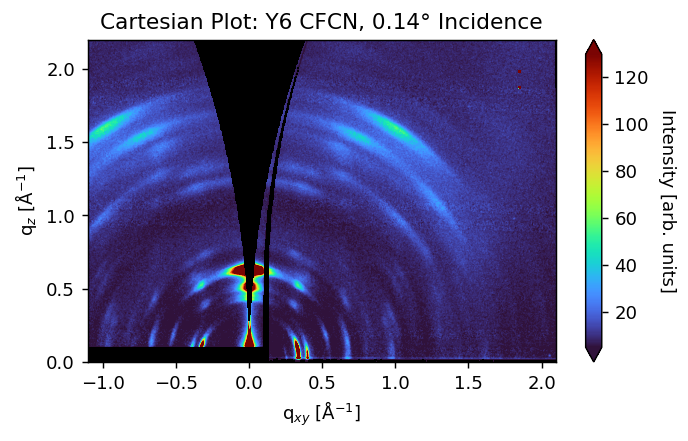

In [17]:
# 2D reciprocal space cartesian plots
qxy_min = -1.1
qxy_max = 2.1
qz_min = 0
qz_max = 2.2


# savePath = outPath.joinpath('var/recip_plots_v1')
# savePath = outPath.joinpath('fix/recip_plots_v1')

# selected_attrs_dict = {'incident_angle':['th0.080', 'th0.140']}
selected_attrs_dict = {'material': ['Y6'], 'solvent': ['CFCN'], 'incident_angle':['th0.140']}
# selected_attrs_dict = {'material': ['Y6', 'Y6BO'], 'solvent': ['CFCN']}
# selected_attrs_dict = {'material': ['PM6'], 'solvent': ['CFCN']}
# selected_attrs_dict = {}

selected_DAs = select_attrs(DS.data_vars.values(), selected_attrs_dict)
for DA in tqdm(selected_DAs):
    # Slice data for selected q ranges (will need to rename q_xy if dimensions are differently named)
    sliced_DA = DA.sel(q_xy=slice(qxy_min, qxy_max), q_z=slice(qz_min, qz_max))
    
    real_min = float(sliced_DA.compute().quantile(0.05))
    cmin = 1 if real_min < 1 else real_min

    cmax = float(sliced_DA.compute().quantile(0.997))   
    
    # Plot
    ax = sliced_DA.plot.imshow(cmap=cmap, norm=plt.Normalize(cmin, cmax), interpolation='antialiased', figsize=(5.5,3.3))
    ax.colorbar.set_label('Intensity [arb. units]', rotation=270, labelpad=15)
    # ax.axes.set(aspect='equal', title=f'Cartesian Plot: {DA.material} {DA.solvent} {DA.rpm}, {float(DA.incident_angle[2:])}° Incidence',
    #             xlabel='q$_{xy}$ [Å$^{-1}$]', ylabel='q$_z$ [Å$^{-1}$]')
    ax.axes.set(aspect='equal', title=f'Cartesian Plot: {DA.material} {DA.solvent}, {float(DA.incident_angle[2:])}° Incidence',
                xlabel='q$_{xy}$ [Å$^{-1}$]', ylabel='q$_z$ [Å$^{-1}$]')
    ax.figure.set(tight_layout=True, dpi=130)
    
    # ax.figure.savefig(savePath.joinpath(f'{DA.material}-{DA.solvent}-{DA.rpm}_qxy{qxy_min}to{qxy_max}_qz{qz_min}to{qz_max}_{DA.incident_angle}.png'), dpi=150)
    # ax.figure.savefig(savePath.joinpath(f'{DA.material}-{DA.solvent}_qxy{qxy_min}to{qxy_max}_qz{qz_min}to{qz_max}_{DA.incident_angle}.png'), dpi=150)

    plt.show()
    plt.close('all')

In [18]:
cmin

4.971629416935693

In [19]:
cmax

129.72182201182113

In [11]:
recip_DA = selected_DAs[0].compute()
recip_DA = recip_DA.sel(q_xy=slice(qxy_min, qxy_max), q_z=slice(qz_min, qz_max))
recip_DA

<xarray.DataArray '1306712' (q_z: 553, q_xy: 779)>
array([[           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       ...,
       [9.67860289e+00, 7.35732265e+00, 7.17682179e+00, ...,
        4.50967741e-03,            nan,            nan],
       [6.83771458e+00, 7.81851130e+00, 6.74653425e+00, ...,
        4.19382975e-03,            nan,            nan],
       [7.56364555e+00, 6.48680171e+00, 7.98942597e+00, ...,
        3.72406653e-03,            nan,            nan]])
Coordinates:
  * q_xy     (q_xy) float64 -1.1 -1.096 -1.091 -1.087 ... 2.088 2.092 2.096
  * q_z      (q_z) float64 0.001109 0.005091 0.009073 ... 2.191 2.195 2.199
Attributes:
    detector:        wax.tiff
    detector_pos:    pos1
    exposure_time:   10.00s
    incident_angle:  th0.140
    material:        Y6
    project:         AL
    sample_pos:      x0.000
    scan_id:         1306712
    solvent:         CFCN

In [12]:
display(recip_DA.data.shape)
display(recip_DA.q_xy.data.shape)
display(recip_DA.q_z.data.shape)

(553, 779)

(779,)

(553,)

In [13]:
np.save(outPath.joinpath('data_Y6_10CNCF_Si.npy'), recip_DA.data)
np.save(outPath.joinpath('qxy_Y6_10CNCF_Si.npy'), recip_DA.q_xy.data)
np.save(outPath.joinpath('qz_Y6_10CNCF_Si.npy'), recip_DA.q_z.data)

In [14]:
outPath

PosixPath('/nsls2/data/cms/proposals/2023-3/pass-311415/AL_processed_data/PM6-Y6series/bcy673')

In [ ]:
# # Yoneda peak check
# qxy_min = 0.22
# qxy_max = 2
# qz_min = -0.01
# qz_max = 0.05

# selected_DAs = select_attrs(DS.data_vars.values(), selected_attrs_dict)
# for DA in tqdm(selected_DAs):
#     # Slice data for selected q ranges (will need to rename q_xy if dimensions are differently named)
#     sliced_DA = DA.sel(q_xy=slice(qxy_min, qxy_max), q_z=slice(qz_min, qz_max))
#     qz_integrated_DA = sliced_DA.sum('q_xy')
    
#     # Plot
#     qz_integrated_DA.plot.line(label=DA.incident_angle)
    
# plt.legend()
# plt.grid(visible=True, which='major', axis='x')
# plt.show()

In [ ]:
# # A way to save data as csv files
# for DA in tqdm(DS.data_vars.values()):
#     # qxy columns, qz rows
#     DA.to_pandas().to_csv(outPath.joinpath('PM6-Y6_waxs', f'cartesian-2D_{DA.polymer}-{DA.weight_percent}_{DA.incident_angle}_{DA.scan_id}.csv'))

### 1D Qxy or Qz integrated lincuts

## Polar plots

### Load dataset

In [ ]:
filename = 'fix_caked_stitched.zarr'
DS = xr.open_zarr(zarrsPath.joinpath(filename))
DS = DS.where(DS>1e-6)
DS

In [ ]:
### Apply a sin chi correction
sin_chi_DA = np.sin(np.radians(np.abs(DS.chi)))

corr_DS = DS.copy()
# corr_DS = corr_DS * sin_chi_DA  # This works mathematically, but does not preserve attributes
for var in corr_DS.data_vars:
    corrected = corr_DS[var] * sin_chi_DA
    corr_DS[var].values = corrected.values
    
corr_DS

In [ ]:
### Fold sin(chi) corrected dataset

folded_corr_DAs = []
for DA in tqdm(corr_DS.data_vars.values()):
    folded_corr_DAs.append(fold_image(DA, 'chi'))

### 2D caked images

#### Unfolded raw(chi) intensity

In [ ]:
# Polar plots, for raw(chi) intensities

# Set chi range: Full range
chi_min = None
chi_max = None
q_min = None
q_max = None

# savePath = outPath.joinpath('var/caked_plots_v1')
savePath = outPath.joinpath('fix/caked_plots_v1')

# selected_attrs_dict = {'incident_angle':['th0.080', 'th0.140']}
# selected_attrs_dict = {'material': ['PM6']}
selected_attrs_dict = {}

selected_DAs = select_attrs(DS.data_vars.values(), selected_attrs_dict)
    
for DA in tqdm(selected_DAs):
    # Slice dataarray to select plotting region 
    sliced_DA = DA.sel(chi=slice(chi_min,chi_max), qr=slice(q_min, q_max))
    
    # Set color limits
    real_min = float(sliced_DA.compute().quantile(0.01))
    cmin = 1 if real_min < 1 else real_min

    cmax = float(sliced_DA.compute().quantile(0.995))       
    
    # Plot sliced dataarray
    ax = sliced_DA.plot.imshow(cmap=cmap, norm=plt.Normalize(cmin, cmax), figsize=(5,4), interpolation='antialiased')  # plot, optional parameter interpolation='antialiased' for image smoothing

    # ax.axes.set(title=f'Polar plot: {DA.material} {DA.solvent} {DA.rpm}, $\\alpha_i$ = {float(DA.incident_angle[2:])}°, raw intensity')
    ax.axes.set(title=f'Polar plot: {DA.material} {DA.solvent}, $\\alpha_i$ = {float(DA.incident_angle[2:])}°, raw intensity')

    ax.colorbar.set_label('Raw intensity [arb. units]', rotation=270, labelpad=15)  # set colorbar label & parameters 
    ax.axes.set(xlabel='q$_r$ [Å$^{-1}$]', ylabel='$\chi$ [°]')  # set title, axis labels, misc
    ax.figure.set(tight_layout=True, dpi=130)  # Adjust figure dpi & plotting style
    
    
    # Uncomment below line and set savepath/savename for saving plots, I usually like to check 
    # ax.figure.savefig(savePath.joinpath(f'rawchi_{DA.material}-{DA.solvent}-{DA.rpm}_chi{chi_min}to{chi_max}_q{q_min}to{q_max}_{DA.incident_angle}.png'), dpi=150)
    # ax.figure.savefig(savePath.joinpath(f'rawchi_{DA.material}-{DA.solvent}_chi{chi_min}to{chi_max}_q{q_min}to{q_max}_{DA.incident_angle}.png'), dpi=150)

    plt.show()  # Comment to mute plotting output
    plt.close('all')

#### Folded raw(chi) intensity

In [ ]:
# Polar plots, for FOLDED raw(chi) intensities

# Set chi range: Full range
chi_min = None
chi_max = None
q_min = None
q_max = None

savePath = outPath.joinpath('PM6-Y6series/caked_plots_v1')

selected_attrs_dict = {}
selected_DAs = select_attrs(DS.data_vars.values(), selected_attrs_dict)
    
for DA in tqdm(selected_DAs):
    DA = fold_image(DA, 'chi')

    # Set color limits
    real_min = float(DA.compute().quantile(0.01))
    cmin = 1 if real_min < 1 else real_min

    cmax = float(DA.compute().quantile(0.995))  
    
    # Slice dataarray to select plotting region 
    sliced_DA = DA.sel(chi=slice(chi_min,chi_max), qr=slice(q_min, q_max))     
    
    # Plot sliced dataarray
    ax = sliced_DA.plot.imshow(cmap=cmap, norm=plt.Normalize(cmin, cmax), figsize=(5,4), interpolation='antialiased')  # plot, optional parameter interpolation='antialiased' for image smoothing
    ax.axes.set(title=f'Folded Polar Plot: {DA.material} {DA.solvent} {DA.rpm}, {float(DA.incident_angle[2:])}° Incidence, Raw Intensity')
    ax.colorbar.set_label('Raw Intensity [arb. units]', rotation=270, labelpad=15)  # set colorbar label & parameters 
    ax.axes.set(xlabel='q$_r$ [Å$^{-1}$]', ylabel='$\chi$ [°]')  # set title, axis labels, misc
    ax.figure.set(tight_layout=True, dpi=130)  # Adjust figure dpi & plotting style
    
    plt.show()  # Comment to mute plotting output
    
    # Uncomment below line and set savepath/savename for saving plots, I usually like to check 
    # ax.figure.savefig(savePath.joinpath(f'rawchi-folded_{DA.material}-{DA.solvent}-{DA.rpm}_chi{chi_min}to{chi_max}_q{q_min}to{q_max}_{DA.incident_angle}.png'), dpi=150)
    plt.close('all')

#### Unfolded sin(chi) intensity

In [ ]:
# Polar plots, for sin(chi) intensities

# Set chi range: Full range
chi_min = -90
chi_max = 90
q_min = None
q_max = None

savePath = outPath.joinpath('A1-3set_waxs/caked_plots_v1')
    
for DA in tqdm(selected_corr_DAs):
    # Slice dataarray to select plotting region 
    sliced_DA = DA.sel(chi=slice(chi_min,chi_max), qr=slice(q_min, q_max))
    
    # Set color limits
    real_min = float(sliced_DA.compute().quantile(0.01))
    cmin = 1 if real_min < 1 else real_min

    cmax = float(sliced_DA.compute().quantile(0.995))       
    
    # Plot sliced dataarray
    ax = sliced_DA.plot.imshow(cmap=cmap, norm=plt.Normalize(cmin, cmax), figsize=(5,4), interpolation='antialiased')  # plot, optional parameter interpolation='antialiased' for image smoothing
    ax.axes.set(title=f'Polar Plot: {DA.film}, {float(DA.incident_angle[2:])}° Incidence, sin($\chi$) Corrected')
    ax.colorbar.set_label('Intensity * sin($\chi$) [arb. units]', rotation=270, labelpad=15)  # set colorbar label & parameters 
    ax.axes.set(xlabel='q$_r$ [Å$^{-1}$]', ylabel='$\chi$ [°]')  # set title, axis labels, misc
    ax.figure.set(tight_layout=True, dpi=130)  # Adjust figure dpi & plotting style
    
    plt.show()  # Comment to mute plotting output
    
    # Uncomment below line and set savepath/savename for saving plots, I usually like to check 
    # ax.figure.savefig(savePath.joinpath(f'sinchi_{DA.film}_chi{chi_min}to{chi_max}_q{q_min}to{q_max}_{DA.incident_angle}.png'), dpi=150)
    plt.close('all')

#### Folded sin(chi) intensity

In [ ]:
%matplotlib inline

In [ ]:
# Polar plots, for FOLDED sin(chi) intensities

# Set chi range: Full range
chi_min = 10
chi_max = 82
q_min = 0.1
q_max = 2.04

# Set savePath
# savePath = outPath.joinpath('var/caked_plots_v1')
savePath = outPath.joinpath('fix/caked_plots_v1')

# selected_attrs_dict = {'incident_angle':['th0.080', 'th0.140']}
selected_attrs_dict = {'material': ['PM6']}
# selected_attrs_dict = {'material': ['Y6'], 'solvent': ['CB']}
# selected_attrs_dict = {}

selected_DAs = select_attrs(folded_corr_DAs, selected_attrs_dict)    
for DA in tqdm(selected_DAs):
    # Slice dataarray to select plotting region 
    sliced_DA = DA.sel(chi=slice(chi_min,chi_max), qr=slice(q_min, q_max))
    
    # Set color limits
    real_min = float(sliced_DA.compute().quantile(0.01))
    cmin = 1 if real_min < 1 else real_min

    cmax = float(sliced_DA.compute().quantile(0.995))       
    
    # Plot sliced dataarray
    ax = sliced_DA.plot.imshow(origin='upper', cmap=cmap, norm=plt.Normalize(cmin, cmax), figsize=(5,4))  # plot, optional parameter interpolation='antialiased' for image smoothing
    # ax.axes.set(title=f'Folded polar plot: {DA.material} {DA.solvent} {DA.rpm}, $\\alpha_i$ = {float(DA.incident_angle[2:])}°, sin($\chi$) corr.')
    ax.axes.set(title=f'Folded polar plot: {DA.material} {DA.solvent}, $\\alpha_i$ = {float(DA.incident_angle[2:])}°, sin($\chi$) corr.')
    ax.colorbar.set_label('Intensity * sin($\chi$) [arb. units]', rotation=270, labelpad=15)  # set colorbar label & parameters 
    ax.axes.set(xlabel='q$_r$ [Å$^{-1}$]', ylabel='$\chi$ [°]')  # set title, axis labels, misc
    ax.figure.set(tight_layout=True, dpi=130)  # Adjust figure dpi & plotting style
    
    
    # Uncomment below line and set savepath/savename for saving plots, I usually like to check 
    # ax.figure.savefig(savePath.joinpath(f'sinchi-folded_{DA.material}-{DA.solvent}-{DA.rpm}_chi{chi_min}to{chi_max}_q{q_min}to{q_max}_{DA.incident_angle}.png'), dpi=150)
    # ax.figure.savefig(savePath.joinpath(f'sinchi-folded_{DA.material}-{DA.solvent}_chi{chi_min}to{chi_max}_q{q_min}to{q_max}_{DA.incident_angle}.png'), dpi=150)

    plt.show()  # Comment to mute plotting output
    plt.close('all')

### 1D linecuts along chi

In [ ]:
import matplotlib.ticker as ticker

In [ ]:
import matplotlib.colors as mcolors

In [ ]:
def darken_colors(color_array, factor):
    """
    Darken an array of RGB colors where 0 is white and 1 is black.
    
    :param color_array: An array of RGB colors in the range [0, 1] where 0 is white and 1 is black
    :param factor: A float between 0 and 1, where 0 has no change and 1 is fully black
    :return: The darkened color array
    """
    darkened_colors = color_array + (1 - color_array) * factor
    return np.clip(darkened_colors, 0, 1)  # Ensures values stay within valid range

In [ ]:
%matplotlib widget

In [ ]:
# Set lims
oop_chi_min = 10
oop_chi_max = 30

ip_chi_min = 65
ip_chi_max = 82

q_min = 0.1
q_max = 2.04
# q_min = 0.2
# q_max = 0.8

# Set savePath
# savePath = outPath.joinpath('var/stacked_linecut_plots_v1')
savePath = outPath.joinpath('fix/stacked_linecut_plots_lamellanormed_v1')

# selected_attrs_dict = {'incident_angle':['th0.080', 'th0.140'],
#                        'material':['Y6']}
selected_attrs_dict = {'material':['PM6']}
# selected_attrs_dict = {}

# group_size = 2
group_size = 4

selected_DAs = select_attrs(folded_corr_DAs, selected_attrs_dict)
DA_sublists = [selected_DAs[i:i + group_size] for i in range(0, len(selected_DAs), group_size)]

# colors = plt.cm.tab20c_r(np.linspace(0,1,20))[:16][::2]  # for 2 incident angles
colors = plt.cm.tab20c_r(np.linspace(0,1,20))[:16]  # for 4 incident angles
colors = darken_colors(colors, -0.5)

for DA_sublist in tqdm(DA_sublists):
    # Sort by incident angle:
    DA_sublist = sorted(DA_sublist, key = lambda x: x.incident_angle)
    
    # Define the figure and subplots
    fig, axs = plt.subplots(4, 1, figsize=(6, 8), sharex=True, dpi=120)

    # Adjust the spacing between plots
    fig.subplots_adjust(hspace=0.005)  # Adjust this value as needed to minimize white space
    
    for i, DA in enumerate(DA_sublist):        
        # Plotting each line in its subplot
        # OOP
        OOP_linecut_DA = DA.sel(chi=slice(oop_chi_min, oop_chi_max), qr=slice(q_min,q_max)).integrate('chi') / np.abs(oop_chi_max - oop_chi_min)
        OOP_linecut_DA = OOP_linecut_DA / float(OOP_linecut_DA.sel(qr=slice(0.2,0.4)).max())
        OOP_linecut_DA.plot.line(color=colors[i], ax=axs[0], label=f'$\\alpha_i$ = {float(DA.incident_angle[2:])}°')

        # Diagonal
        Diagonal_linecut_DA = DA.sel(chi=slice(oop_chi_max, ip_chi_min), qr=slice(q_min,q_max)).integrate('chi') / np.abs(ip_chi_min - oop_chi_max)
        # Diagonal_linecut_DA.plot.line(color=colors[i+2], ax=axs[1], label=f'Diagonal, {oop_chi_max}-{ip_chi_min}°' + r' $\chi$, ' + f'$\\alpha_i$ = {float(DA.incident_angle[2:])}°')
        Diagonal_linecut_DA = Diagonal_linecut_DA / float(Diagonal_linecut_DA.sel(qr=slice(0.2,0.4)).max())
        Diagonal_linecut_DA.plot.line(color=colors[i+4], ax=axs[1], label=f'$\\alpha_i$ = {float(DA.incident_angle[2:])}°')

        # IP
        IP_linecut_DA = DA.sel(chi=slice(ip_chi_min, ip_chi_max), qr=slice(q_min,q_max)).integrate('chi') / np.abs(ip_chi_max - ip_chi_min)
        # IP_linecut_DA.plot.line(color=colors[i+4], ax=axs[2], label=f'In-plane, {ip_chi_min}-{ip_chi_max}°' + r' $\chi$, ' + f'$\\alpha_i$ = {float(DA.incident_angle[2:])}°')
        IP_linecut_DA = IP_linecut_DA / float(IP_linecut_DA.sel(qr=slice(0.2,0.4)).max())
        IP_linecut_DA.plot.line(color=colors[i+8], ax=axs[2], label=f'$\\alpha_i$ = {float(DA.incident_angle[2:])}°')

        # Full
        Full_linecut_DA = DA.sel(chi=slice(oop_chi_min, ip_chi_max), qr=slice(q_min,q_max)).integrate('chi') / 90
        # Full_linecut_DA.plot.line(color=colors[i+6], ax=axs[3], label=f'Full, {oop_chi_min}-{ip_chi_max}°' + r' $\chi$, ' + f'$\\alpha_i$ = {float(DA.incident_angle[2:])}°')
        Full_linecut_DA = Full_linecut_DA / float(Full_linecut_DA.sel(qr=slice(0.2,0.4)).max())
        Full_linecut_DA.plot.line(color=colors[i+12], ax=axs[3], label=f'$\\alpha_i$ = {float(DA.incident_angle[2:])}°')

    # Add legends and gridlines to each subplot
    for ax in axs:
        ax.grid(True, which='major', axis='x')  # Add gridlines
        ax.xaxis.set_major_locator(ticker.AutoLocator())  # Set major tick locator
        ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())  # Set minor tick locator
        ax.set_ylabel('')

    axs[0].text(0.5, 0.88, f'Out-of-plane, {oop_chi_min}-{oop_chi_max}°' + r' $\chi$', fontsize=12,
                horizontalalignment='center', transform=axs[0].transAxes)
    axs[1].text(0.5, 0.88, f'Diagonal, {oop_chi_max}-{ip_chi_min}°' + r' $\chi$', fontsize=12,
                horizontalalignment='center', transform=axs[1].transAxes)
    axs[2].text(0.5, 0.88, f'In-plane, {ip_chi_min}-{ip_chi_max}°' + r' $\chi$', fontsize=12,
                horizontalalignment='center', transform=axs[2].transAxes)
    axs[3].legend(loc='upper center', title=f'Full, {oop_chi_min}-{ip_chi_max}°' + r' $\chi$',
                  fontsize=10, title_fontsize='large')
       

    # Add axis labels
    axs[-1].set_xlabel('$q_r$ $[Å^{-1}]$', fontsize=12)
    fig.text(0.01, 0.5, 'Integrated intensities [arb. units]', va='center', rotation='vertical', fontsize=12)

    fig.suptitle(f'{DA.material} {DA.solvent}: $\\chi$-integrated linecuts, $\\chi$-width normed', y=0.91, fontsize=14)
    # fig.suptitle(f'{DA.material} {DA.solvent} {DA.rpm} $\\chi$-integrated linecuts, $\\chi$-width normed', y=0.91, fontsize=14)

    # fig.savefig(savePath.joinpath(f'sinchi-folded_{DA.material}-{DA.solvent}_q{q_min}to{q_max}.png'), dpi=150, bbox_inches='tight')
    # fig.savefig(savePath.joinpath(f'sinchi-folded_{DA.material}-{DA.solvent}-{DA.rpm}_q{q_min}to{q_max}.png'), dpi=150, bbox_inches='tight')
    
    plt.show()
    plt.close('all')

In [ ]:
# Set lims
oop_chi_min = 8
oop_chi_max = 30

ip_chi_min = 65
ip_chi_max = 87

q_min = 0.1
q_max = 2.04

# Set savePath
# savePath = outPath.joinpath('PM6-Y6series/var/linecut_plots_v1')
savePath = outPath.joinpath('PM6-Y6series/fix/linecut_plots_v1')

# selected_attrs_dict = {'incident_angle':['th0.080', 'th0.140']}
selected_attrs_dict = {}

selected_DAs = select_attrs(folded_corr_DAs, selected_attrs_dict)
for DA in tqdm(selected_DAs[:1]):
    # OOP
    OOP_linecut_DA = DA.sel(chi=slice(oop_chi_min, oop_chi_max), qr=slice(q_min,q_max)).integrate('chi')
    OOP_linecut_DA.plot.line(figsize=(6,4), label=f'Out-of-plane, {oop_chi_min} to {oop_chi_max}°' + r' $\chi$')

    # A plot.line xarray plot does not return an AxesImage object like imshow does
    # Can use plt.gca() and plt.gcf() to access the axes & figure parameters
    ax = plt.gca()
    fig = plt.gcf()

    # IP
    ax2 = ax.twinx()
    IP_linecut_DA = DA.sel(chi=slice(ip_chi_min, ip_chi_max), qr=slice(q_min,q_max)).integrate('chi')
    IP_linecut_DA.plot.line(color='C1', ax=ax2, label=f'In-plane, {ip_chi_min} to {ip_chi_max}°' + r' $\chi$')
    
    # ax.set(title=f'{DA.material} {DA.solvent} {DA.rpm} 22° Linecuts, {float(DA.incident_angle[2:])}° Incidence',
    #        ylabel='Out-of-plane Intensity [arb. units]', xlabel='q$_r$ [Å$^{-1}$]')
    ax.set(title=f'{DA.material} {DA.solvent} 22° Linecuts, {float(DA.incident_angle[2:])}° Incidence',
           ylabel='Out-of-plane Intensity [arb. units]', xlabel='q$_r$ [Å$^{-1}$]')
    ax2.set(ylabel='In-plane Intensity [arb. units]')
    
    ax.grid(visible=True, which='major', axis='x')
    fig.set(tight_layout=True, dpi=130)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1))
    ax2.legend(loc='upper center', bbox_to_anchor=(0.5, 0.91)) 
    
    # ax.figure.savefig(savePath.joinpath(f'sinchi-folded_{DA.material}-{DA.solvent}-{DA.rpm}_chi{chi_min}to{chi_max}_q{q_min}to{q_max}_{DA.incident_angle}.png'), dpi=150)
    # ax.figure.savefig(savePath.joinpath(f'sinchi-folded_{DA.material}-{DA.solvent}_chi{chi_min}to{chi_max}_q{q_min}to{q_max}_{DA.incident_angle}.png'), dpi=150)

    plt.show()
    plt.close('all')

### 1D line fitting*
Use lmfit to perform the linefits

In [ ]:
from scipy import optimize, signal
from lmfit import models

#### Messy A-series line fitting below

In [ ]:
# def fit_plotter(q, I, out):
#     """
#     Plots a figure with 2 axes, the full fit on a log scale on the left and the components in normal scale on the right
#     """
#     fig, (ax1, ax2) = plt.subplots(1,2)
#     fig.set(size_inches=(12,4))
    
#     ax1.plot(q, I, label='data')
#     ax1.plot(q, out.best_fit, label='full_fit')
#     ax1.set(xlabel='Q [Å$^{-1}$]', ylabel='Intensity [arb. units]')
#     ax1.legend(loc='upper left')
    
#     ax2.plot(q, I, label='data')
#     ax2.plot(q, out.best_fit, label='full_fit')
#     for key in out.eval_components():
#         ax2.plot(q, out.eval_components()[key], label=f'{key}')
#     ax2.set(xlabel='Q [Å$^{-1}$]')
#     ax2.legend(loc='upper left')
    
#     return (ax1, ax2), fig

In [ ]:
# A1
intensity_type = 'raw'
if intensity_type == 'corr':
    DA = selected_corr_DAs[0].compute()
elif intensity_type == 'raw':
    DA = selected_raw_DAs[0].compute()
else:
    print('Must select intensity type')

OOP_linecut_DA = DA.sel(chi=slice(chi_min, chi_max), qr=slice(0.3, 1.9)).mean('chi')

point_x = 0.3
point_y = float(DA.sel(chi=slice(chi_min, chi_max), qr=slice(point_x-0.01, point_x+0.01)).mean('qr').mean('chi'))
point_y = point_y - point_y*(0.08)

x = OOP_linecut_DA.qr.data
y = OOP_linecut_DA.data

# Define all models to include in fitting
bkg_mod = models.LinearModel(prefix='bkg_')
pars = bkg_mod.make_params()
pars = bkg_mod.make_params(intercept=point_y, slope=0)
pars['bkg_intercept'].set(vary=False)
pars['bkg_slope'].set(vary=False)

pk1_mod = models.PseudoVoigtModel(prefix='pk1_')
# pars = pk1_mod.make_params(center=0.55)
pars += pk1_mod.guess(y, x, center=0.55)
# pars['pk1_amplitude'].set(min=0.5)
pars['pk1_amplitude'].set(min=0)

# pk2_mod = models.LorentzianModel(prefix='pk2_')
pk2_mod = models.PseudoVoigtModel(prefix='pk2_')

pars += pk2_mod.guess(y, x, center=1.7)
# pars['pk2_center'].set(max = 0.62, min = 0.58)
# pars['pk2_sigma'].set(max = 0.03)
pars['pk2_amplitude'].set(min=0)

pk3_mod = models.PseudoVoigtModel(prefix='pk3_')
pars += pk3_mod.guess(y, x, center=0.8)
pars['pk3_center'].set(max=0.9, min = 0.7)
pars['pk3_amplitude'].set(min=0)


# Combine into full model
mod = bkg_mod + pk1_mod + pk2_mod + pk3_mod

# Run fit and store all info in a ModelResult object
out = mod.fit(y, pars, x=x)
FWHM = np.round(float(out.params['pk2_fwhm']), 2)
center = np.round(float(out.params['pk2_center']), 2)
Lc = np.round((2*np.pi*0.9)/FWHM, 2)

# Plot
axs, fig = fit_plotter(x, y, out)
fig.set(tight_layout=True)

if intensity_type == 'corr':
    axs[0].set(ylabel=f'Meaned (Intensity * sin($\chi$)) [arb. units]', title=f'Scherrer Coherence Length = {Lc} Å')
    axs[1].set(title=f'Pi-Pi Peak: FWHM = {FWHM}' + ' Å$^{-1}$, ' + f'Peak Center = {center}' + ' Å$^{-1}$')
    fig.suptitle(f'{DA.film} Film, sin($\chi$)-corrected Linecut Fit, {chi_min}° to {chi_max}° $\chi$, Incident Angle = {DA.incident_angle[2:-1]}°')    
elif intensity_type =='raw':
    axs[0].set(ylabel=f'Meaned Raw Intensity [arb. units]', title=f'Scherrer Coherence Length = {Lc} Å')
    axs[1].set(title=f'Pi-Pi Peak: FWHM = {FWHM}' + ' Å$^{-1}$, ' + f'Peak Center = {center}' + ' Å$^{-1}$')
    fig.suptitle(f'{DA.film} Film, Raw Intensity Linecut Fit, {chi_min}° to {chi_max}° $\chi$, Incident Angle = {DA.incident_angle[2:-1]}°')

fig.savefig(outPath.joinpath('A1-3set_waxs/linecut_fits', f'{DA.film}_{intensity_type}_{DA.incident_angle}_{chi_min}to{chi_max}chi.png'), dpi=120)
plt.show()


print(f'FWHM = {FWHM}, Lc = {Lc}\n')
display(out.best_values)

In [ ]:
# A2
intensity_type = 'corr'
if intensity_type == 'corr':
    DA = selected_corr_DAs[1].compute()
elif intensity_type == 'raw':
    DA = selected_raw_DAs[1].compute()
else:
    print('Must select intensity type')
    
OOP_linecut_DA = DA.sel(chi=slice(chi_min, chi_max), qr=slice(0.3, 1.9)).mean('chi')

point_x = 0.3
point_y = float(DA.sel(chi=slice(chi_min, chi_max), qr=slice(point_x-0.01, point_x+0.01)).mean('qr').mean('chi'))
point_y = point_y - point_y*(0.08)

x = OOP_linecut_DA.qr.data
y = OOP_linecut_DA.data

# Define all models to include in fitting
bkg_mod = models.LinearModel(prefix='bkg_')
# pars = bkg_mod.make_params()
pars = bkg_mod.make_params(intercept=point_y, slope=0)
pars['bkg_intercept'].set(vary=False)
pars['bkg_slope'].set(vary=False)

pk1_mod = models.PseudoVoigtModel(prefix='pk1_')
# pars = pk1_mod.make_params(center=0.55)
pars += pk1_mod.guess(y, x, center=0.55)
# pars['pk1_amplitude'].set(min=0.5)

pk2_mod = models.PseudoVoigtModel(prefix='pk2_')
pars += pk2_mod.guess(y, x, center=1.7)
# pars['pk2_center'].set(max = 0.62, min = 0.58)
# pars['pk2_sigma'].set(max = 0.03)
# pars['pk2_amplitude'].set(min=0.5)

# Combine into full model
mod = bkg_mod + pk1_mod + pk2_mod

# Run fit and store all info in a ModelResult object
out = mod.fit(y, pars, x=x)
FWHM = np.round(float(out.params['pk2_fwhm']), 2)
center = np.round(float(out.params['pk2_center']), 2)
Lc = np.round((2*np.pi*0.9)/FWHM, 2)

# Plot
axs, fig = fit_plotter(x, y, out)
fig.set(tight_layout=True)

if intensity_type == 'corr':
    axs[0].set(ylabel=f'Meaned (Intensity * sin($\chi$)) [arb. units]', title=f'Scherrer Coherence Length = {Lc} Å')
    axs[1].set(title=f'Pi-Pi Peak: FWHM = {FWHM}' + ' Å$^{-1}$, ' + f'Peak Center = {center}' + ' Å$^{-1}$')
    fig.suptitle(f'{DA.film} Film, sin($\chi$)-corrected Linecut Fit, {chi_min}° to {chi_max}° $\chi$, Incident Angle = {DA.incident_angle[2:-1]}°')    
elif intensity_type =='raw':
    axs[0].set(ylabel=f'Meaned Raw Intensity [arb. units]', title=f'Scherrer Coherence Length = {Lc} Å')
    axs[1].set(title=f'Pi-Pi Peak: FWHM = {FWHM}' + ' Å$^{-1}$, ' + f'Peak Center = {center}' + ' Å$^{-1}$')
    fig.suptitle(f'{DA.film} Film, Raw Intensity Linecut Fit, {chi_min}° to {chi_max}° $\chi$, Incident Angle = {DA.incident_angle[2:-1]}°')

# fig.savefig(outPath.joinpath('A1-3set_waxs/linecut_fits', f'{DA.film}_{intensity_type}_{DA.incident_angle}_{chi_min}to{chi_max}chi.png'), dpi=120)
plt.show()

print(f'FWHM = {FWHM}, Lc = {Lc}\n')
display(out.best_values)

In [ ]:
# A3
intensity_type = 'raw'
if intensity_type == 'corr':
    DA = selected_corr_DAs[2].compute()
elif intensity_type == 'raw':
    DA = selected_raw_DAs[2].compute()
else:
    print('Must select intensity type')
    
OOP_linecut_DA = DA.sel(chi=slice(chi_min, chi_max), qr=slice(0.3, 1.9)).mean('chi')

point_x = 0.3
point_y = float(DA.sel(chi=slice(chi_min, chi_max), qr=slice(point_x-0.01, point_x+0.01)).mean('qr').mean('chi'))
point_y = point_y - point_y*(0.08)

x = OOP_linecut_DA.qr.data
y = OOP_linecut_DA.data

# Define all models to include in fitting
bkg_mod = models.LinearModel(prefix='bkg_')
# pars = bkg_mod.make_params()
pars = bkg_mod.make_params(intercept=point_y, slope=0)
pars['bkg_intercept'].set(vary=False)
pars['bkg_slope'].set(vary=False)

pk1_mod = models.PseudoVoigtModel(prefix='pk1_')
# pars = pk1_mod.make_params(center=0.55)
pars += pk1_mod.guess(y, x, center=0.55)
# pars['pk1_amplitude'].set(min=0.5)

pk2_mod = models.PseudoVoigtModel(prefix='pk2_')
pars += pk2_mod.guess(y, x, center=1.7)
# pars['pk2_center'].set(max = 0.62, min = 0.58)
# pars['pk2_sigma'].set(max = 0.03)
# pars['pk2_amplitude'].set(min=0.5)

# Combine into full model
mod = bkg_mod + pk1_mod + pk2_mod

# Run fit and store all info in a ModelResult object
out = mod.fit(y, pars, x=x)
FWHM = np.round(float(out.params['pk2_fwhm']), 2)
center = np.round(float(out.params['pk2_center']), 2)
Lc = np.round((2*np.pi*0.9)/FWHM, 2)

# Plot
axs, fig = fit_plotter(x, y, out)
fig.set(tight_layout=True)
FWHM = np.round(float(out.params['pk2_fwhm']), 2)
Lc = np.round((2*np.pi*0.9)/FWHM, 2)

if intensity_type == 'corr':
    axs[0].set(ylabel=f'Meaned (Intensity * sin($\chi$)) [arb. units]', title=f'Scherrer Coherence Length = {Lc} Å')
    axs[1].set(title=f'Pi-Pi Peak: FWHM = {FWHM}' + ' Å$^{-1}$, ' + f'Peak Center = {center}' + ' Å$^{-1}$')
    fig.suptitle(f'{DA.film} Film, sin($\chi$)-corrected Linecut Fit, {chi_min}° to {chi_max}° $\chi$, Incident Angle = {DA.incident_angle[2:-1]}°')    
elif intensity_type =='raw':
    axs[0].set(ylabel=f'Meaned Raw Intensity [arb. units]', title=f'Scherrer Coherence Length = {Lc} Å')
    axs[1].set(title=f'Pi-Pi Peak: FWHM = {FWHM}' + ' Å$^{-1}$, ' + f'Peak Center = {center}' + ' Å$^{-1}$')
    fig.suptitle(f'{DA.film} Film, Raw Intensity Linecut Fit, {chi_min}° to {chi_max}° $\chi$, Incident Angle = {DA.incident_angle[2:-1]}°')

fig.savefig(outPath.joinpath('A1-3set_waxs/linecut_fits', f'{DA.film}_{intensity_type}_{DA.incident_angle}_{chi_min}to{chi_max}chi.png'), dpi=120)
plt.show()

print(f'FWHM = {FWHM}, Lc = {Lc}\n')
display(out.best_values)


#### Less messy PM6 films fitting below:

In [ ]:
%matplotlib inline

In [ ]:
def lamella_lmfit(sliced_DA, q_min, q_max, bkg_point_x=0.6):
    """
    Function currently utilizes global variables, define in notebook!
    
    """
    point_x = bkg_point_x
    point_y = float(sliced_DA.sel(qr=slice(point_x-0.01, point_x+0.01)).mean('qr'))
    point_y = point_y - point_y*(0.05)

    x = sliced_DA.qr.data
    y = sliced_DA.data

    # Define all models to include in fitting
    bkg_mod = models.LinearModel(prefix='bkg_')
    pars = bkg_mod.make_params(intercept=point_y, slope=0)
    pars['bkg_intercept'].set(vary=True)
    pars['bkg_slope'].set(vary=False)
    
    exp_mod = models.ExponentialModel(prefix='exp_')
    pars += exp_mod.make_params(decay=0.05, amplitude=1)
    pars['exp_decay'].set(min=0.01, max=100)
    pars['exp_amplitude'].set(min=0.1, max=1000)
    
    pk1_mod = models.PseudoVoigtModel(prefix='pk1_')
    pars += pk1_mod.guess(y, x, center=0.32)
    pars['pk1_amplitude'].set(min=0)

    # Combine into full model
    mod = bkg_mod + exp_mod + pk1_mod

    # Run fit and store all info in a ModelResult object
    out = mod.fit(y, pars, x=x)
    return out

def full_lamella_fit(sliced_DA, q_min, q_max, bkg_point_x=0.6, show_plot=True):   
    # Run lmfit
    out = lamella_lmfit(sliced_DA, q_min, q_max, bkg_point_x)
    FWHM = np.round(float(out.params['pk1_fwhm']), 2)
    Lc = np.round((2*np.pi*0.9)/float(out.params['pk1_fwhm']), 2)
    center = np.round(float(out.params['pk1_center']), 2)
    dspacing = np.round((2*np.pi)/float(out.params['pk1_center']), 2)
    
    amplitude = np.round(float(out.params['pk1_amplitude']), 3)
    
    rsquared = np.round(out.rsquared, 3)
    redchi = np.round(out.redchi, 4)

    AA1 = '$\AA^{-1}$'
    
    # Plot
    q = sliced_DA.qr.data
    I = sliced_DA.data
    
    fig, ax = plt.subplots()
    fig.set(size_inches=(6.5,3.5), dpi=120, tight_layout=True)
    fig.suptitle(
        f'Lamella peak: {sliced_DA.material} {sliced_DA.solvent}, $\\alpha$={float(sliced_DA.incident_angle[2:])}°; {sliced_DA.chi_slice}° chi; peak area = {amplitude}',
        fontsize=12, y=0.93, x=0.53)
       
    ax.plot(q, I, label='data', linewidth=2.5)
    ax.plot(q, out.best_fit, '--', label='full_fit')
    for key in out.eval_components():
        ax.plot(q, out.eval_components()[key], label=f'{key}')
    ax.set(xlabel=f'Q [{AA1}]', ylabel='Intensity [arb. units]')
    ax.set_title(
        f'Center = {center}, FWHM = {FWHM} {AA1} (d-spacing = {dspacing}, $L_c$ = {Lc} $\AA$)')
    ax.legend(title=f'$R^2$ = {rsquared}, $\chi_r$ = {redchi}')
    ax.grid(visible=True, axis='x')
        
    
    FWHM = np.round(float(out.params['pk1_fwhm']), 2)
    Lc = np.round((2*np.pi*0.9)/FWHM, 2)  # calculate scherrer coherence length

    if show_plot:
        plt.show()
    
    return out, fig, ax

In [ ]:
avg_thicknesses = {
    'PM6_CB': 115,
    'PM6_CF': 190,
    'PM6_CBCN': 40,
    # 'PM6_CFCN': 105  # a fudge value to make it line up nicely for comparing in stacked linecuts
    'PM6_CFCN': 150  # the real average value

}

low_thicknesses = {
    'PM6_CB': 110,
    'PM6_CF': 180,
    'PM6_CBCN': 30,
    'PM6_CFCN': 140
}

high_thicknesses = {
    'PM6_CB': 130,
    'PM6_CF': 200,
    'PM6_CBCN': 50,
    'PM6_CFCN': 170
}

thicknesses = high_thicknesses

In [ ]:
%matplotlib widget

In [ ]:
plt.close('all')

In [ ]:
# Overview plot(s)

# Set lims
oop_chi_min = 10
oop_chi_max = 30

ip_chi_min = 65
ip_chi_max = 82

# q_min = 0.1
# q_max = 2.04

# q_min = 0.15
# q_max = 0.45

q_min = 0.55
q_max = 2.04

# Set savePath
# savePath = outPath.joinpath('fix/stacked_linecut_plots_v1')

# for th in ['th0.080', 'th0.100', 'th0.120', 'th0.140']:
for th in ['th0.120']:
    # Select attributes
    selected_attrs_dict = {'material': ['PM6'],  
                           # 'solvent': ['CF', 'CB'],
                           # 'solvent': ['CFCN', 'CBCN'],
                           'incident_angle': [th]}
    selected_DAs = select_attrs(folded_corr_DAs, selected_attrs_dict)


    # Define the figure and subplots
    fig, axs = plt.subplots(4, 1, figsize=(6, 8), sharex=True, dpi=120)
    colors = plt.cm.turbo(np.linspace(0,0.9,len(selected_DAs)))  

    # Adjust the spacing between plots
    fig.subplots_adjust(hspace=0.005)  # Adjust this value as needed to minimize white space

    for i, DA in enumerate(tqdm(selected_DAs)):
        # DA = DA.copy()
        # print(thicknesses[f'{DA.material}_{DA.solvent}'])
        DA.data = DA.data / thicknesses[f'{DA.material}_{DA.solvent}']  # thickness normalization!
        
        # Plotting each line in its subplot
        # OOP
        OOP_linecut_DA = DA.sel(chi=slice(oop_chi_min, oop_chi_max), qr=slice(q_min,q_max)).integrate('chi') / np.abs(oop_chi_max - oop_chi_min)
        # OOP_linecut_DA = OOP_linecut_DA / float(OOP_linecut_DA.sel(qr=slice(0.2,0.4)).max())  # normalize to peak maximum
        OOP_linecut_DA.plot.line(color=colors[i], ax=axs[0], label=f'{DA.solvent}')

        # Diagonal
        Diagonal_linecut_DA = DA.sel(chi=slice(oop_chi_max, ip_chi_min), qr=slice(q_min,q_max)).integrate('chi') / np.abs(ip_chi_min - oop_chi_max)
        # Diagonal_linecut_DA.plot.line(color=colors[i+2], ax=axs[1], label=f'Diagonal, {oop_chi_max}-{ip_chi_min}°' + r' $\chi$, ' + f'$\\alpha_i$ = {float(DA.incident_angle[2:])}°')
        # Diagonal_linecut_DA = Diagonal_linecut_DA / float(Diagonal_linecut_DA.sel(qr=slice(0.2,0.4)).max())  # normalize to peak maximum
        Diagonal_linecut_DA.plot.line(color=colors[i], ax=axs[1], label=f'{DA.solvent}')

        # IP
        IP_linecut_DA = DA.sel(chi=slice(ip_chi_min, ip_chi_max), qr=slice(q_min,q_max)).integrate('chi') / np.abs(ip_chi_max - ip_chi_min)
        # IP_linecut_DA.plot.line(color=colors[i+4], ax=axs[2], label=f'In-plane, {ip_chi_min}-{ip_chi_max}°' + r' $\chi$, ' + f'$\\alpha_i$ = {float(DA.incident_angle[2:])}°')
        # IP_linecut_DA = IP_linecut_DA / float(IP_linecut_DA.sel(qr=slice(0.2,0.4)).max())  # normalize to peak maximum
        IP_linecut_DA.plot.line(color=colors[i], ax=axs[2], label=f'{DA.solvent}')

        # Full
        Full_linecut_DA = DA.sel(chi=slice(oop_chi_min, ip_chi_max), qr=slice(q_min,q_max)).integrate('chi') / 90
        # Full_linecut_DA.plot.line(color=colors[i+6], ax=axs[3], label=f'Full, {oop_chi_min}-{ip_chi_max}°' + r' $\chi$, ' + f'$\\alpha_i$ = {float(DA.incident_angle[2:])}°')
        # Full_linecut_DA = Full_linecut_DA / float(Full_linecut_DA.sel(qr=slice(0.2,0.4)).max())  # normalize to peak maximum
        Full_linecut_DA.plot.line(color=colors[i], ax=axs[3], label=f'{DA.solvent}')

    # Add legends and gridlines to each subplot
    for ax in axs:
        ax.grid(True, which='major', axis='x')  # Add gridlines
        ax.xaxis.set_major_locator(ticker.AutoLocator())  # Set major tick locator
        ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())  # Set minor tick locator
        ax.set_ylabel('')
        # ax.set_ylim(top=0.3, bottom=0)

    axs[0].text(0.01, 0.88, f'Out-of-plane, {oop_chi_min}-{oop_chi_max}°' + r' $\chi$', fontsize=12,
                horizontalalignment='left', transform=axs[0].transAxes)
    axs[1].text(0.01, 0.88, f'Diagonal, {oop_chi_max}-{ip_chi_min}°' + r' $\chi$', fontsize=12,
                horizontalalignment='left', transform=axs[1].transAxes)
    axs[2].text(0.01, 0.88, f'In-plane, {ip_chi_min}-{ip_chi_max}°' + r' $\chi$', fontsize=12,
                horizontalalignment='left', transform=axs[2].transAxes)
    axs[3].text(0.01, 0.88, f'Full, {oop_chi_min}-{ip_chi_max}°' + r' $\chi$', fontsize=12,
                horizontalalignment='left', transform=axs[3].transAxes)
    axs[0].legend(fontsize=10)


    # Add axis labels
    axs[-1].set_xlabel('$q_r$ $[Å^{-1}]$', fontsize=12)
    fig.text(0.01, 0.5, 'Peak-normalized intensities [arb. units]', va='center', rotation='vertical', fontsize=12)

    fig.suptitle(f'{DA.material} {float(DA.incident_angle[2:])}° incidence: $\\chi$ linecuts, $\\chi$-width normed', y=0.91, fontsize=13)
    
    # savePath = outPath.joinpath('fix/stacked_linecuts_lamella-region_v1')
    # savePath.mkdir(exist_ok=True)
    # fig.savefig(savePath.joinpath(f'sinchi-folded_{DA.material}_{DA.incident_angle}_q{q_min}to{q_max}.png'), dpi=120)    
    
    plt.show()
    
    plt.close('all')

In [ ]:
sliced_DA

In [ ]:
def full_lmfit(sliced_DA, q_min, q_max):
    """
    Function currently utilizes global variables, define in notebook!
    
    """
    # point_x = float(sliced_DA.min())
    # point_y = float(sliced_DA.sel(qr=slice(point_x-0.01, point_x+0.01)).mean('qr'))
    
    point_y = float(sliced_DA.min())
    point_y = point_y - point_y*(0.05)

    x = sliced_DA.qr.data
    y = sliced_DA.data

    # Define all models to include in fitting
    bkg_mod = models.LinearModel(prefix='bkg_')
    pars = bkg_mod.make_params(intercept=point_y, slope=0)
    pars['bkg_intercept'].set(min=(point_y-point_y*(0.5)), vary=True)
    pars['bkg_slope'].set(vary=False)
    
    exp_mod = models.ExponentialModel(prefix='exp_')
    pars += exp_mod.make_params(decay=0.05, amplitude=1)
    pars['exp_decay'].set(min=0.01, max=0.09)
    pars['exp_amplitude'].set(min=0.1, max=1)
    
    lamella_mod = models.PseudoVoigtModel(prefix='lamella_')  # lamella peak at 0.32
    pars += lamella_mod.make_params(center={'value':0.31, 'min':0.29, 'max':0.33}, 
                                    sigma ={'value':0.09/2, 'min':0.01/2, 'max':0.2/2})
    pars['lamella_amplitude'].set(min=0)
    
    backbone_mod = models.PseudoVoigtModel(prefix='backbone_')  # backbone peak at 0.66
    pars += backbone_mod.guess(y, x, center=0.66)
    pars['backbone_amplitude'].set(min=0)
    pars['backbone_center'].set(min=0.63, max=0.69)

    pk0p9_mod = models.PseudoVoigtModel(prefix='pk0p9_')  # 300 (or 001) peak around 0.9
    pars += pk0p9_mod.guess(y, x, center=0.91)
    pars['pk0p9_amplitude'].set(min=0)
    pars['pk0p9_center'].set(min=0.88, max=0.98)

    pk1p2_mod = models.PseudoVoigtModel(prefix='pk1p2_')  # 021? peak around 1.2
    # pars += pk1p2_mod.guess(y, x, center=1.2)
    pars += pk1p2_mod.make_params(center={'value':1.2, 'min':1.15, 'max':1.28}, 
                                  sigma ={'value':0.8/2, 'min':0.01/2, 'max':3/2})
    pars['pk1p2_amplitude'].set(min=0)
    # pars['pk1p2_center'].set(min=1.18, max=1.26)
    
    pkgroup_mod = models.PseudoVoigtModel(prefix='pkgroup_')  # broad collection of slip-stack peaks around 1.2-2
    # pars += pkgroup_mod.guess(y, x, center=1.4)
    pars += pkgroup_mod.make_params(center={'value':1.4, 'min':1.3, 'max':1.6}, 
                                  sigma ={'value':0.8/2, 'min':0.01/2, 'max':3/2})
    pars['pkgroup_amplitude'].set(min=0)
    # pars['pkgroup_center'].set(min=1.3, max=1.6)

    pipi_mod = models.PseudoVoigtModel(prefix='pipi_')  # pi-pi peak! around 1.73
    pars += pipi_mod.guess(y, x, center=1.73)
    pars['pipi_amplitude'].set(min=0)
    pars['pipi_center'].set(min=1.7, max=1.76)
    
    pk1p86_mod = models.PseudoVoigtModel(prefix='pk1p86_')  # highq peak
    pars += pk1p86_mod.guess(y, x, center=1.86)
    pars['pk1p86_amplitude'].set(min=0)
    pars['pk1p86_center'].set(min=1.84, max=1.9)

    # Combine into full model
    mod = bkg_mod + exp_mod + lamella_mod + backbone_mod + pk0p9_mod + pk1p2_mod + pkgroup_mod + pipi_mod + pk1p86_mod

    # Run fit and store all info in a ModelResult object
    out = mod.fit(y, pars, x=x)
    return out

def full_fit(sliced_DA, q_min, q_max, show_plot=True):   
    # Run lmfit
    out = full_lmfit(sliced_DA, q_min, q_max)
    # FWHM = np.round(float(out.params['pk1_fwhm']), 2)
    # Lc = np.round((2*np.pi*0.9)/float(out.params['pk1_fwhm']), 2)
    # center = np.round(float(out.params['pk1_center']), 2)
    # dspacing = np.round((2*np.pi)/float(out.params['pk1_center']), 2)
    
    # amplitude = np.round(float(out.params['pk1_amplitude']), 3)
    
    rsquared = np.round(out.rsquared, 3)
    redchi = np.round(out.redchi, 4)

    AA1 = '$\AA^{-1}$'
    
    # Plot
    q = sliced_DA.qr.data
    I = sliced_DA.data
    
    fig, ax = plt.subplots()
    fig.set(size_inches=(6.5,3.5), dpi=120, tight_layout=True)
    fig.suptitle(
        f'Full fit: {sliced_DA.material} {sliced_DA.solvent}, $\\alpha$={float(sliced_DA.incident_angle[2:])}°; {sliced_DA.chi_slice}° chi',
        fontsize=12, y=0.93, x=0.53)
       
    ax.plot(q, I, label='data', linewidth=2.5)
    ax.plot(q, out.best_fit, '--', label='full_fit')
    for key in out.eval_components():
        ax.plot(q, out.eval_components()[key], label=f'{key}')
    ax.set(xlabel=f'Q [{AA1}]', ylabel='Intensity [arb. units]', yscale='linear')
    # ax.set_title(
    #     f'Center = {center}, FWHM = {FWHM} {AA1} (d-spacing = {dspacing}, $L_c$ = {Lc} $\AA$)')
    ax.legend(title=f'$R^2$ = {rsquared}, $\chi_r$ = {redchi}', loc='upper left', bbox_to_anchor=(1,1.05))
    ax.grid(visible=True, axis='x')
        
    
    # FWHM = np.round(float(out.params['pk1_fwhm']), 2)
    # Lc = np.round((2*np.pi*0.9)/FWHM, 2)  # calculate scherrer coherence length

    if show_plot:
        plt.show()
    
    return out, fig, ax

In [ ]:
def highq_lmfit(sliced_DA, q_min, q_max):
    """
    Function currently utilizes global variables, define in notebook!
    
    """
    # point_x = float(sliced_DA.min())
    # point_y = float(sliced_DA.sel(qr=slice(point_x-0.01, point_x+0.01)).mean('qr'))
    
    point_y = float(sliced_DA.min())
    point_y = point_y - point_y*(0.05)

    x = sliced_DA.qr.data
    y = sliced_DA.data

    # Define all models to include in fitting
    bkg_mod = models.LinearModel(prefix='bkg_')
    pars = bkg_mod.make_params(intercept=point_y, slope=0)
    pars['bkg_intercept'].set(min=(point_y-point_y*(0.05)), vary=True)
    pars['bkg_slope'].set(vary=False)
    
    # exp_mod = models.ExponentialModel(prefix='exp_')
    # pars += exp_mod.make_params(decay=0.05, amplitude=1)
    # pars['exp_decay'].set(min=0.01, max=0.09)
    # pars['exp_amplitude'].set(min=0.1, max=1)
    
#     lamella_mod = models.PseudoVoigtModel(prefix='lamella_')  # lamella peak at 0.32
#     pars += lamella_mod.make_params(center={'value':0.31, 'min':0.29, 'max':0.33}, 
#                                     sigma ={'value':0.09/2, 'min':0.01/2, 'max':0.2/2})
#     pars['lamella_amplitude'].set(min=0)
    
    backbone_mod = models.PseudoVoigtModel(prefix='backbone_')  # backbone peak at 0.66
    pars += backbone_mod.guess(y, x, center=0.66)
    pars['backbone_amplitude'].set(min=0)
    pars['backbone_center'].set(min=0.63, max=0.69)

    pk0p9_mod = models.PseudoVoigtModel(prefix='pk0p9_')  # 300 (or 001) peak around 0.9
    pars += pk0p9_mod.guess(y, x, center=0.91)
    pars['pk0p9_amplitude'].set(min=0)
    pars['pk0p9_sigma'].set(max=1/2)
    pars['pk0p9_center'].set(min=0.88, max=0.98)

    pk1p2_mod = models.PseudoVoigtModel(prefix='pk1p2_')  # 021? peak around 1.2
    # pars += pk1p2_mod.guess(y, x, center=1.2)
    pars += pk1p2_mod.make_params(center={'value':1.2, 'min':1.15, 'max':1.28}, 
                                  sigma ={'value':0.8/2, 'min':0.01/2, 'max':3/2})
    pars['pk1p2_amplitude'].set(min=0)
    # pars['pk1p2_center'].set(min=1.15, max=1.28)
    
    pkgroup_mod = models.PseudoVoigtModel(prefix='pkgroup_')  # broad collection of slip-stack peaks around 1.2-2
    pars += pkgroup_mod.guess(y, x, center=1.4)
    pars += pkgroup_mod.make_params(center={'value':1.4, 'min':1.3, 'max':1.6}, 
                                    sigma ={'value':0.8/2, 'min':0.01/2, 'max':3/2})
    pars['pkgroup_amplitude'].set(min=0)
    # pars['pkgroup_center'].set(min=1.3, max=1.6)

    pipi_mod = models.PseudoVoigtModel(prefix='pipi_')  # pi-pi peak! around 1.73
    pars += pipi_mod.guess(y, x, center=1.73)
    pars['pipi_amplitude'].set(min=0)
    pars['pipi_center'].set(min=1.7, max=1.76)
    
    pk1p86_mod = models.PseudoVoigtModel(prefix='pk1p86_')  # highq peak
    pars += pk1p86_mod.guess(y, x, center=1.86)
    pars['pk1p86_amplitude'].set(min=0)
    pars['pk1p86_center'].set(min=1.85, max=1.9)

    # Combine into full model
    mod = bkg_mod + backbone_mod + pk0p9_mod + pk1p2_mod + pkgroup_mod + pipi_mod + pk1p86_mod

    # Run fit and store all info in a ModelResult object
    out = mod.fit(y, pars, x=x)
    return out

def highq_fit(sliced_DA, q_min, q_max, show_plot=True):   
    # Run lmfit
    out = highq_lmfit(sliced_DA, q_min, q_max)
    # FWHM = np.round(float(out.params['pk1_fwhm']), 2)
    # Lc = np.round((2*np.pi*0.9)/float(out.params['pk1_fwhm']), 2)
    # center = np.round(float(out.params['pk1_center']), 2)
    # dspacing = np.round((2*np.pi)/float(out.params['pk1_center']), 2)
    
    # amplitude = np.round(float(out.params['pk1_amplitude']), 3)
    
    rsquared = np.round(out.rsquared, 3)
    redchi = np.round(out.redchi, 4)

    AA1 = '$\AA^{-1}$'
    
    # Plot
    q = sliced_DA.qr.data
    I = sliced_DA.data
    
    fig, ax = plt.subplots()
    fig.set(size_inches=(6.5,3.5), dpi=120, tight_layout=True)
    fig.suptitle(
        f'High Q fit: {sliced_DA.material} {sliced_DA.solvent}, $\\alpha$={float(sliced_DA.incident_angle[2:])}°; {sliced_DA.chi_slice}° chi',
        fontsize=12, y=0.93, x=0.53)
       
    ax.plot(q, I, label='data', linewidth=2.5)
    ax.plot(q, out.best_fit, '--', label='full_fit')
    for key in out.eval_components():
        ax.plot(q, out.eval_components()[key], label=f'{key}')
    ax.set(xlabel=f'Q [{AA1}]', ylabel='Intensity [arb. units]', yscale='linear')
    # ax.set_title(
    #     f'Center = {center}, FWHM = {FWHM} {AA1} (d-spacing = {dspacing}, $L_c$ = {Lc} $\AA$)')
    ax.legend(title=f'$R^2$ = {rsquared}, $\chi_r$ = {redchi}', loc='upper left', bbox_to_anchor=(1,1.05))
    ax.grid(visible=True, axis='x')
        
    
    # FWHM = np.round(float(out.params['pk1_fwhm']), 2)
    # Lc = np.round((2*np.pi*0.9)/FWHM, 2)  # calculate scherrer coherence length

    if show_plot:
        plt.show()
    
    return out, fig, ax

In [ ]:
def pipi_lmfit(sliced_DA, q_min, q_max):
    """
    Function currently utilizes global variables, define in notebook!
    
    """
    # point_x = float(sliced_DA.min())
    # point_y = float(sliced_DA.sel(qr=slice(point_x-0.01, point_x+0.01)).mean('qr'))
    
    point_y = float(sliced_DA.min())
    point_y = point_y - point_y*(0.05)

    x = sliced_DA.qr.data
    y = sliced_DA.data

    # Define all models to include in fitting
    bkg_mod = models.LinearModel(prefix='bkg_')
    pars = bkg_mod.make_params(intercept=point_y, slope=0)
    pars['bkg_intercept'].set(min=(point_y-point_y*(0.05)), vary=False)
    pars['bkg_slope'].set(vary=False)
    
    # exp_mod = models.ExponentialModel(prefix='exp_')
    # pars += exp_mod.make_params(decay=0.05, amplitude=1)
    # pars['exp_decay'].set(min=0.01, max=0.09)
    # pars['exp_amplitude'].set(min=0.1, max=1)
    
    pkgroup_mod = models.PseudoVoigtModel(prefix='pkgroup_')  # broad collection of slip-stack peaks around 1.2-2
    pars += pkgroup_mod.guess(y, x, center=1.4)
    # pars += pkgroup_mod.make_params(center={'value':1.4, 'min':1.3, 'max':1.6}, 
    #                                 sigma ={'value':0.8/2, 'min':0.01/2, 'max':3/2})
    pars['pkgroup_amplitude'].set(min=0)
    pars['pkgroup_center'].set(min=1.3, max=1.55)

    pipi_mod = models.PseudoVoigtModel(prefix='pipi_')  # pi-pi peak! around 1.73
    pars += pipi_mod.guess(y, x, center=1.73)
    pars['pipi_amplitude'].set(min=0)
    pars['pipi_center'].set(min=1.7, max=1.76)
    
    pk1p86_mod = models.PseudoVoigtModel(prefix='pk1p86_')  # highq peak
    pars += pk1p86_mod.guess(y, x, center=1.86)
    pars['pk1p86_amplitude'].set(min=0)
    pars['pk1p86_center'].set(min=1.85, max=1.9)

    # Combine into full model
    mod = bkg_mod + pkgroup_mod + pipi_mod + pk1p86_mod

    # Run fit and store all info in a ModelResult object
    out = mod.fit(y, pars, x=x)
    return out

def pipi_fit(sliced_DA, q_min, q_max, show_plot=True):   
    # Run lmfit
    out = pipi_lmfit(sliced_DA, q_min, q_max)
    FWHM = np.round(float(out.params['pipi_fwhm']), 2)
    Lc = np.round((2*np.pi*0.9)/float(out.params['pipi_fwhm']), 2)
    center = np.round(float(out.params['pipi_center']), 2)
    dspacing = np.round((2*np.pi)/float(out.params['pipi_center']), 2)
    
    amplitude = np.round(float(out.params['pipi_amplitude']), 3)
    
    rsquared = np.round(out.rsquared, 3)
    redchi = np.round(out.redchi, 4)

    AA1 = '$\AA^{-1}$'
    
    # Plot
    q = sliced_DA.qr.data
    I = sliced_DA.data
    
    fig, ax = plt.subplots()
    fig.set(size_inches=(6.5,3.5), dpi=120, tight_layout=True)
    fig.suptitle(
        f'Pi-pi fit: {sliced_DA.material} {sliced_DA.solvent}, $\\alpha$={float(sliced_DA.incident_angle[2:])}°; {sliced_DA.chi_slice}° chi; peak area = {amplitude}',
        fontsize=12, y=0.93, x=0.53)
       
    ax.plot(q, I, label='data', linewidth=2.5)
    ax.plot(q, out.best_fit, '--', label='full_fit')
    for key in out.eval_components():
        ax.plot(q, out.eval_components()[key], label=f'{key}')
    ax.set(xlabel=f'Q [{AA1}]', ylabel='Intensity [arb. units]', yscale='linear')
    ax.set_title(
        f'Center = {center}, FWHM = {FWHM} {AA1} (d-spacing = {dspacing}, $L_c$ = {Lc} $\AA$)', x=0.7)
    ax.legend(title=f'$R^2$ = {rsquared}, $\chi_r$ = {redchi}', loc='upper left', bbox_to_anchor=(1,1))
    ax.grid(visible=True, axis='x')
        
    
    # FWHM = np.round(float(out.params['pk1_fwhm']), 2)
    # Lc = np.round((2*np.pi*0.9)/FWHM, 2)  # calculate scherrer coherence length

    if show_plot:
        plt.show()
    
    return out, fig, ax

In [ ]:
def calc_Lc(FWHM):
    return np.round((2*np.pi*0.9)/FWHM, 2)

In [ ]:
%matplotlib inline

In [ ]:
plt.close('all')

In [ ]:
# Peak fitting

# Select attributes
selected_attrs_dict = {'material': ['PM6'],  
                       'solvent': ['CF'],
                       # 'solvent': ['CFCN', 'CBCN'],
                       # 'incident_angle': ['th0.080', 'th0.100', 'th0.120', 'th0.140']}
                       'incident_angle': ['th0.120']}
# selected_attrs_dict = {}

selected_DAs = select_attrs(folded_corr_DAs, selected_attrs_dict)


all_outs = {}
for DA in tqdm(selected_DAs):
    DA = DA.copy()
    DA.data = DA.data / thicknesses[f'{DA.material}_{DA.solvent}']  # thickness normalization!
        
    # Set lims
    oop_chi_min = 10
    oop_chi_max = 30

    ip_chi_min = 65
    ip_chi_max = 82

    # Define chi slice dictionary:
    chi_slices = {'OOP': slice(oop_chi_min, oop_chi_max),
                  'diag': slice(oop_chi_max, ip_chi_min),
                  'IP': slice(ip_chi_min, ip_chi_max),
                  'full': slice(oop_chi_min, ip_chi_max)}

    # Set q limits for fitting area
    q_min = 0.1
    q_max = 2.04

    # Loop over each chi slice: make linecut DA, run lmfit, plot, & store results
    outs = {}
    for key in chi_slices.keys():
        sliced_DA = DA.sel(chi=chi_slices[key], qr=slice(q_min,q_max)).integrate('chi') / np.abs(chi_slices[key].stop - chi_slices[key].start)
        # sliced_DA = sliced_DA / float(sliced_DA.sel(qr=slice(0.2,0.4)).max())  # normalize by peak maximum
        sliced_DA.attrs = DA.attrs # assign attrs
        sliced_DA.attrs['chi_slice'] = (chi_slices[key].start, chi_slices[key].stop)  # add chi slice attribute
        sliced_DA = sliced_DA.where(~np.isnan(sliced_DA), drop=True)  # drop nans
        
        # outs[key], fig, ax = pipi_fit(sliced_DA, q_min, q_max, show_plot=False)
        outs[key], fig, ax = full_fit(sliced_DA, q_min, q_max, show_plot=True)
        plt.close('all')
        
        # # savePath = outPath.joinpath('fix/pipi_linefits_lowthick_v1')
        # # savePath = outPath.joinpath('fix/pipi_linefits_avgthick_v1')
        # savePath = outPath.joinpath('fix/pipi_linefits_highthick_v1')
        # savePath.mkdir(exist_ok=True)
        # fig.savefig(savePath.joinpath(f'sinchi-folded_{DA.material}-{DA.solvent}_{DA.incident_angle}_chi{chi_slices[key].start}to{chi_slices[key].stop}_q{q_min}to{q_max}.png'), dpi=120)
        
    all_outs[f'{DA.material}_{DA.solvent}_{DA.incident_angle}'] = outs

In [ ]:
all_outs

In [ ]:
all_outs['']

In [ ]:
all_outs['PM6_CFCN_th0.120']['OOP'].params

In [ ]:
display(all_outs['PM6_CB_th0.120']['OOP'].params['exp_amplitude'])
display(all_outs['PM6_CB_th0.120']['OOP'].params['exp_decay'])

In [ ]:
display(all_outs['PM6_CF_th0.120']['OOP'].params['exp_amplitude'])
display(all_outs['PM6_CF_th0.120']['OOP'].params['exp_decay'])

In [ ]:
display(all_outs['PM6_CBCN_th0.120']['OOP'].params['exp_amplitude'])
display(all_outs['PM6_CBCN_th0.120']['OOP'].params['exp_decay'])

In [ ]:
display(all_outs['PM6_CFCN_th0.120']['OOP'].params['exp_amplitude'])
display(all_outs['PM6_CFCN_th0.120']['OOP'].params['exp_decay'])

In [ ]:
display(all_outs['PM6_CBCN_th0.120']['OOP'].params['exp_amplitude'])
display(all_outs['PM6_CBCN_th0.120']['OOP'].params['exp_decay'])

In [ ]:
# Peak fitting

# Select attributes
selected_attrs_dict = {'material': ['PM6'],  
                       # 'solvent': ['CF', 'CB'],
                       # 'solvent': ['CFCN', 'CBCN'],
                       'incident_angle': ['th0.080', 'th0.100', 'th0.120', 'th0.140']}
# selected_attrs_dict = {}

selected_DAs = select_attrs(folded_corr_DAs, selected_attrs_dict)


all_outs = {}
for DA in tqdm(selected_DAs):
    DA = DA.copy()
    DA.data = DA.data / thicknesses[f'{DA.material}_{DA.solvent}']  # thickness normalization!
        
    # Set lims
    oop_chi_min = 10
    oop_chi_max = 30

    ip_chi_min = 65
    ip_chi_max = 82

    # Define chi slice dictionary:
    chi_slices = {'OOP': slice(oop_chi_min, oop_chi_max),
                  'diag': slice(oop_chi_max, ip_chi_min),
                  'IP': slice(ip_chi_min, ip_chi_max),
                  'full': slice(oop_chi_min, ip_chi_max)}

    # Set q limits for fitting area
    q_min = 0.1
    q_max = 0.65

    # Loop over each chi slice: make linecut DA, run lmfit, plot, & store results
    outs = {}
    for key in chi_slices.keys():
        sliced_DA = DA.sel(chi=chi_slices[key], qr=slice(q_min,q_max)).integrate('chi') / np.abs(chi_slices[key].stop - chi_slices[key].start)
        # sliced_DA = sliced_DA / float(sliced_DA.sel(qr=slice(0.2,0.4)).max())  # normalize by peak maximum
        sliced_DA.attrs = DA.attrs # assign attrs
        sliced_DA.attrs['chi_slice'] = (chi_slices[key].start, chi_slices[key].stop)  # add chi slice attribute
        sliced_DA = sliced_DA.where(~np.isnan(sliced_DA), drop=True)  # drop nans
        
        outs[key], fig, ax = full_lamella_fit(sliced_DA, q_min, q_max, show_plot=True)
        plt.close('all')
        
        # savePath = outPath.joinpath('fix/lamella_linefits_lowthick_v1')
        # savePath = outPath.joinpath('fix/lamella_linefits_avgthick_v1')
        # savePath = outPath.joinpath('fix/lamella_linefits_highthick_v1')
        # savePath.mkdir(exist_ok=True)
        # fig.savefig(savePath.joinpath(f'sinchi-folded_{DA.material}-{DA.solvent}_{DA.incident_angle}_chi{chi_slices[key].start}to{chi_slices[key].stop}_q{q_min}to{q_max}.png'), dpi=120)
        
    all_outs[f'{DA.material}_{DA.solvent}_{DA.incident_angle}'] = outs

In [ ]:
savePath

In [ ]:
np.round(all_outs['PM6_CB_th0.120']['OOP'].redchi, 4)

### Pole Figures

#### Pi-pi 

In [ ]:
### Set limits
q_min = 1.6
q_max = 1.9
chi_min = 10
chi_max = 82  # to ~45 least until I mask out the silicon(?) background scattering that interferes

# Set savePath
# savePath = outPath.joinpath('PM6-Y6series/var/pipi_pole_figures_v1')
savePath = outPath.joinpath('PM6-Y6series/fix/pipi_pole_figures_v1')

selected_attrs_dict = {'material':['PM6'], 'incident_angle':['th0.120']}
# selected_attrs_dict = {}

selected_DAs = select_attrs(folded_corr_DAs, selected_attrs_dict)
peak_areas_dict = {}    
for DA in tqdm(selected_DAs):
    chis = DA.chi.sel(chi=slice(chi_min,chi_max)).data
    
    peak_areas = np.array([])
    peak_centers = np.array([])
    
    for chi in chis:
        sliced_DA = DA.sel(qr=slice(q_min-0.1, q_max+0.1), chi=float(chi))

        points_x = [q_min, q_max]
        points_y = [float(sliced_DA.sel(qr=slice(points_x[0]-0.05, points_x[0]+0.05)).mean('qr')), 
                    float(sliced_DA.sel(qr=slice(points_x[1]-0.05, points_x[1]+0.05)).mean('qr'))]
        m = (points_y[1]-points_y[0])/(points_x[1]-points_x[0])
        b = points_y[1] - (m*points_x[1])
        y_fit = np.polyval([m, b], sliced_DA.qr)
        
        sub_sliced_DA = sliced_DA-y_fit

        peak_area = sub_sliced_DA.sel(qr=slice(q_min,q_max)).integrate('qr')
        peak_area = np.nan if peak_area<0 else peak_area  # remove negatives as they are nonphysical
        
        peak_areas = np.append(peak_areas, float(peak_area))
                        
#         # Plot linecuts for each chi
#         fig, ax = plt.subplots()
#         sliced_DA.plot(ax=ax)
#         ax.plot(points_x, points_y)
#         plt.show()

#         plt.close('all')

    normed_peak_areas = peak_areas / np.nansum(peak_areas)
    data = np.vstack((chis, normed_peak_areas)).T
    # peak_areas_dict[DA.attrs['material']+'-'+DA.attrs['solvent']+'-'+DA.attrs['rpm']+'-'+DA.attrs['incident_angle']] = data
    peak_areas_dict[DA.attrs['material']+'-'+DA.attrs['solvent']+'-'+DA.attrs['incident_angle']] = data

    # Individual measurement pole figure plot
    fig, ax = plt.subplots(figsize=(5,3.3))
    fig.set(dpi=120)
    
    ax.plot(chis, normed_peak_areas)
    # fig.suptitle(f'{DA.material} {DA.solvent} {DA.rpm} Pole Figure; $\\alpha_i = $ {DA.incident_angle[2:-1]}°', x=0.54)
    fig.suptitle(f'{DA.material} {DA.solvent} Pole Figure; $\\alpha_i = $ {DA.incident_angle[2:-1]}°', x=0.54)
    ax.set(title=f'{q_min} to {q_max} 1/Å Q Bounds; {chi_min}° to {chi_max}° $\chi$')
    ax.set(xlabel='$\chi$ [°]', ylabel='Integrated Pi-Pi Peak Area [arb. units]')
    plt.subplots_adjust(top=0.85, bottom=0.2, left=0.2)
    
    # fig.savefig(savePath.joinpath(f'{DA.material}-{DA.solvent}-{DA.rpm}_chi{chi_min}to{chi_max}_q{q_min}to{q_max}_{DA.incident_angle}.png'), dpi=150)
    # fig.savefig(savePath.joinpath(f'{DA.material}-{DA.solvent}_chi{chi_min}to{chi_max}_q{q_min}to{q_max}_{DA.incident_angle}.png'), dpi=150)

    plt.show()
    
    plt.close('all')

In [ ]:
### Set savePath
# savePath = outPath.joinpath('var/pipi_pole_figures_v1')
savePath = outPath.joinpath('fix/pipi_pole_figures_v1')

# for th in tqdm(['th0.080', 'th0.100', 'th0.120', 'th0.140']):
for th in tqdm(['th0.120']):
    selected_dict_items = [(name, data) for (name, data) in peak_areas_dict.items() if 
                           # # 'Y7BO-' in name and
                           # 'CF' in name and '3000' in name and 
                           th in name]    
                           # 'CFCN-' in name]    


    fig, ax = plt.subplots(figsize=(5,3.3))
    fig.set(dpi=120)
    
    colors = plt.cm.Dark2(np.linspace(0,1,len(selected_dict_items)))

    for i, (measurement, pole_fig_arr_data) in enumerate(selected_dict_items):
        chis = pole_fig_arr_data[:,0]
        normed_peak_areas = pole_fig_arr_data[:,1]
        ax.plot(chis, normed_peak_areas, color=colors[i], label=measurement)
        
    fig.suptitle('Pole Figure', x=0.55)
    ax.set(title=f'{q_min} to {q_max} 1/Å Q Fit Region; {chi_min}° to {chi_max}° $\chi$')
    ax.set(xlabel='$\chi$ [°]', ylabel='Normalized Peak Area')
    # ax.set_xlim(chi_min,chi_max)
    
    plt.subplots_adjust(top=0.85, bottom=0.2, left=0.2)
    ax.legend()
    
    fig.savefig(savePath.joinpath(f'multiple-PM6_chi{chi_min}to{chi_max}_q{q_min}to{q_max}_{th}.png'), dpi=150)
    
    # plt.show()
    plt.close('all')

#### Lamella

In [ ]:
### Set limits
q_min = 0.2
q_max = 0.45
chi_min = 10
chi_max = 82  # to ~45 least until I mask out the silicon(?) background scattering that interferes

# Set savePath
savePath = outPath.joinpath('PM6-Y6series/lamella_pole_figures_v1')

selected_attrs_dict = {'material':['PM6'], 'incident_angle': ['th0.120']}
selected_DAs = select_attrs(folded_corr_DAs, selected_attrs_dict)
 
peak_areas_dict = {}    
for DA in tqdm(selected_DAs):
    chis = DA.chi.sel(chi=slice(chi_min,chi_max)).data
    
    peak_areas = np.array([])
    peak_centers = np.array([])
    
    for chi in chis:
        sliced_DA = DA.sel(qr=slice(q_min-0.05, q_max+0.05), chi=float(chi))

        points_x = [q_min, q_max]
        points_y = [float(sliced_DA.sel(qr=slice(points_x[0]-0.05, points_x[0]+0.05)).mean('qr')), 
                    float(sliced_DA.sel(qr=slice(points_x[1]-0.05, points_x[1]+0.05)).mean('qr'))]
        # points_y = [float(sliced_DA.sel(qr=q_min, method='nearest')), 
        #             float(sliced_DA.sel(qr=q_max, method='nearest'))]
        m = (points_y[1]-points_y[0])/(points_x[1]-points_x[0])
        b = points_y[1] - (m*points_x[1])
        y_fit = np.polyval([m, b], sliced_DA.qr)
        
        sub_sliced_DA = sliced_DA-y_fit

        peak_area = sub_sliced_DA.sel(qr=slice(q_min,q_max)).integrate('qr')

        # peak_area = sliced_DA.sel(qr=slice(None,0.45)).integrate('qr')
        peak_area = np.nan if peak_area<0 else peak_area  # remove negatives as they are nonphysical
        
        peak_areas = np.append(peak_areas, float(peak_area))
                        
#         # Plot linecuts for each chi
#         fig, ax = plt.subplots()
#         sliced_DA.plot(ax=ax)
#         ax.plot(points_x, points_y)
#         plt.show()

#         plt.close('all')

    normed_peak_areas = peak_areas / np.nansum(peak_areas)
    data = np.vstack((chis, normed_peak_areas)).T
    # peak_areas_dict[DA.attrs['material']+'-'+DA.attrs['solvent']+'-'+DA.attrs['rpm']+'-'+DA.attrs['incident_angle']] = data
    peak_areas_dict[DA.attrs['material']+'-'+DA.attrs['solvent']+'-'+DA.attrs['incident_angle']] = data


    # Individual measurement pole figure plot
    fig, ax = plt.subplots(figsize=(5,3.3))
    fig.set(dpi=120)
    
    ax.plot(chis, normed_peak_areas)
    # fig.suptitle(f'{DA.material} {DA.solvent} {DA.rpm} Pole Figure; $\\alpha_i = $ {DA.incident_angle[2:-1]}°', x=0.54)
    fig.suptitle(f'{DA.material} {DA.solvent} Pole Figure; $\\alpha_i = $ {DA.incident_angle[2:-1]}°', x=0.54)

    ax.set(title=f'{q_min} to {q_max} 1/Å Q Bounds; {chi_min}° to {chi_max}° $\chi$')
    ax.set(xlabel='$\chi$ [°]', ylabel='Integrated Pi-Pi Peak Area [arb. units]')
    plt.subplots_adjust(top=0.85, bottom=0.2, left=0.2)
    
    # fig.savefig(savePath.joinpath(f'{DA.material}-{DA.solvent}-{DA.rpm}_chi{chi_min}to{chi_max}_q{q_min}to{q_max}_{DA.incident_angle}.png'), dpi=150)
    # fig.savefig(savePath.joinpath(f'{DA.material}-{DA.solvent}_chi{chi_min}to{chi_max}_q{q_min}to{q_max}_{DA.incident_angle}.png'), dpi=150)
    
    plt.show()
    
    plt.close('all')

In [ ]:
### Set savePath
# savePath = outPath.joinpath('PM6-Y6series/var/lamella_pole_figures_v1')
savePath = outPath.joinpath('fix/lamella_pole_figures_v1')

# for th in tqdm(['th0.080', 'th0.100', 'th0.120', 'th0.140']):
for th in tqdm(['th0.120']):
    selected_dict_items = [(name, data) for (name, data) in peak_areas_dict.items() if 
                           # # 'Y7BO-' in name and
                           # 'CF' in name and '3000' in name and 
                           # 'CF-' in name]     
                           th in name] 

    fig, ax = plt.subplots(figsize=(5,3.3))
    fig.set(dpi=120)
    
    colors = plt.cm.Dark2(np.linspace(0,1,len(selected_dict_items)))

    for i, (measurement, pole_fig_arr_data) in enumerate(selected_dict_items):
        chis = pole_fig_arr_data[:,0]
        normed_peak_areas = pole_fig_arr_data[:,1]
        ax.plot(chis, normed_peak_areas, color=colors[i], label=measurement)
        
    fig.suptitle('Pole Figure', x=0.55)
    ax.set(title=f'{q_min} to {q_max} 1/Å Q Fit Region ; {chi_min}° to {chi_max}° $\chi$')
    ax.set(xlabel='$\chi$ [°]', ylabel='Normalized Peak Area')
    
    plt.subplots_adjust(top=0.85, bottom=0.2, left=0.2)
    ax.legend()

    # fig.savefig(savePath.joinpath(f'multiple-PM6_chi{chi_min}to{chi_max}_q{q_min}to{q_max}_{th}.png'), dpi=150)


    plt.show()
    plt.close('all')

#### Backbone

In [ ]:
### Set limits
q_min = 0.55
q_max = 0.77
chi_min = 10
chi_max = 82  # to ~45 least until I mask out the silicon(?) background scattering that interferes

# Set savePath
savePath = outPath.joinpath('PM6-Y6series/lamella_pole_figures_v1')

selected_attrs_dict = {'material':['PM6'], 'incident_angle': ['th0.120']}
selected_DAs = select_attrs(folded_corr_DAs, selected_attrs_dict)
 
peak_areas_dict = {}    
for DA in tqdm(selected_DAs):
    chis = DA.chi.sel(chi=slice(chi_min,chi_max)).data
    
    peak_areas = np.array([])
    peak_centers = np.array([])
    
    for chi in chis:
        sliced_DA = DA.sel(qr=slice(q_min, q_max), chi=float(chi))

        points_x = [q_min, q_max]
        points_y = [float(sliced_DA.sel(qr=slice(points_x[0]-0.05, points_x[0]+0.05)).mean('qr')), 
                    float(sliced_DA.sel(qr=slice(points_x[1]-0.05, points_x[1]+0.05)).mean('qr'))]
        # points_y = [float(sliced_DA.sel(qr=q_min, method='nearest')), 
        #             float(sliced_DA.sel(qr=q_max, method='nearest'))]
        m = (points_y[1]-points_y[0])/(points_x[1]-points_x[0])
        b = points_y[1] - (m*points_x[1])
        y_fit = np.polyval([m, b], sliced_DA.qr)
        
        sub_sliced_DA = sliced_DA-y_fit

        peak_area = sub_sliced_DA.sel(qr=slice(q_min,q_max)).integrate('qr')

        # peak_area = sliced_DA.sel(qr=slice(None,0.45)).integrate('qr')
        peak_area = np.nan if peak_area<0 else peak_area  # remove negatives as they are nonphysical
        
        peak_areas = np.append(peak_areas, float(peak_area))
                        
#         # Plot linecuts for each chi
#         fig, ax = plt.subplots()
#         sliced_DA.plot(ax=ax)
#         ax.plot(points_x, points_y)
#         plt.show()

#         plt.close('all')

    normed_peak_areas = peak_areas / np.nansum(peak_areas)
    data = np.vstack((chis, normed_peak_areas)).T
    # peak_areas_dict[DA.attrs['material']+'-'+DA.attrs['solvent']+'-'+DA.attrs['rpm']+'-'+DA.attrs['incident_angle']] = data
    peak_areas_dict[DA.attrs['material']+'-'+DA.attrs['solvent']+'-'+DA.attrs['incident_angle']] = data


    # Individual measurement pole figure plot
    fig, ax = plt.subplots(figsize=(5,3.3))
    fig.set(dpi=120)
    
    ax.plot(chis, normed_peak_areas)
    # fig.suptitle(f'{DA.material} {DA.solvent} {DA.rpm} Pole Figure; $\\alpha_i = $ {DA.incident_angle[2:-1]}°', x=0.54)
    fig.suptitle(f'{DA.material} {DA.solvent} Pole Figure; $\\alpha_i = $ {DA.incident_angle[2:-1]}°', x=0.54)

    ax.set(title=f'{q_min} to {q_max} 1/Å Q Bounds; {chi_min}° to {chi_max}° $\chi$')
    ax.set(xlabel='$\chi$ [°]', ylabel='Integrated Pi-Pi Peak Area [arb. units]')
    plt.subplots_adjust(top=0.85, bottom=0.2, left=0.2)
    
    # fig.savefig(savePath.joinpath(f'{DA.material}-{DA.solvent}-{DA.rpm}_chi{chi_min}to{chi_max}_q{q_min}to{q_max}_{DA.incident_angle}.png'), dpi=150)
    # fig.savefig(savePath.joinpath(f'{DA.material}-{DA.solvent}_chi{chi_min}to{chi_max}_q{q_min}to{q_max}_{DA.incident_angle}.png'), dpi=150)
    
    plt.show()
    
    plt.close('all')

In [ ]:
# Set parameters:
q_min = 0.55
q_max = 0.77
chi_min = 45
chi_max = 82

# Set savePath
# savePath = outPath.joinpath('PM6-Y6series/var/backbone_pole_figures_v1')
savePath = outPath.joinpath('fix/backbone_pole_figures_v1')

# for th in tqdm(['th0.080', 'th0.100', 'th0.120', 'th0.140']):
for th in tqdm(['th0.120']):
    selected_dict_items = [(name, data) for (name, data) in peak_areas_dict.items() if 
                           # # 'Y7BO-' in name and
                           # 'CF' in name and '3000' in name and 
                           # 'CF-' in name]     
                           th in name] 

    fig, ax = plt.subplots(figsize=(5,3.3))
    fig.set(dpi=120)
    
    colors = plt.cm.Dark2(np.linspace(0,1,len(selected_dict_items)))

    for i, (measurement, pole_fig_arr_data) in enumerate(selected_dict_items):
        chis = pole_fig_arr_data[:,0]
        normed_peak_areas = pole_fig_arr_data[:,1]
        ax.plot(chis, normed_peak_areas, color=colors[i], label=measurement)
        
    fig.suptitle('Pole Figure', x=0.55)
    ax.set(title=f'{q_min} to {q_max} 1/Å Q Fit Region ; {chi_min}° to {chi_max}° $\chi$')
    ax.set(xlabel='$\chi$ [°]', ylabel='Normalized Peak Area')
    ax.set_xlim(45,None)
    
    plt.subplots_adjust(top=0.85, bottom=0.2, left=0.2)
    ax.legend()
    
    
    fig.savefig(savePath.joinpath(f'multiple-PM6_chi{chi_min}to{chi_max}_q{q_min}to{q_max}_{th}.png'), dpi=150)


    # plt.show()
    plt.close('all')

# Original notebook code

### 2D plots

#### Caked Images

In [ ]:
filename = 'fix_caked_stitched.zarr'
DS = xr.open_zarr(zarrsPath.joinpath(filename))
DS = DS.where(DS>1e-5)
DS

In [ ]:
# # How one could apply a sin chi correction
# sin_chi_DA = np.sin(np.radians(np.abs(DA.chi)))
# # sin_chi_DA

# corr_DA = DA * sin_chi_DA
# # corr_DA

In [ ]:
# A way to select dataarrays based on attribute values:
selected_DAs = [da for da in DS.data_vars.values() if 
                da.attrs['material']]
                # da.attrs['material'] in ['Y6', 'Y7'] and 
                # da.attrs['incident_angle'] in ['th0.120', 'th0.140']]

len(selected_DAs)

In [ ]:
# Plot and optionally save selected dataarrays:
# Set chi range: Full range
chi_min = -90
chi_max = 90

for DA in tqdm(selected_DAs):
    # Slice dataarray to select plotting region 
    sliced_DA = DA.sel(chi=slice(chi_min,chi_max))
    
    # real_min = float(DA.sel(q_xy=slice(-0.5, -0.1), q_z=slice(0.1, 0.4)).compute().quantile(1e-3))
    real_min = float(DA.compute().quantile(0.01))
    cmin = 1 if real_min < 1 else real_min
    
    # cmax = float(DA.sel(q_xy=slice(-0.5, -0.1), q_z=slice(0.1, 2)).compute().quantile(1))   
    cmax = float(DA.compute().quantile(0.99))   
    
    # Plot sliced dataarray
    ax = sliced_DA.plot.imshow(cmap=cmap, norm=plt.Normalize(cmin, cmax), figsize=(5,4), interpolation='antialiased')  # plot, optional parameter interpolation='antialiased' for image smoothing
    ax.colorbar.set_label('Intensity [arb. units]', rotation=270, labelpad=15)  # set colorbar label & parameters 
    ax.axes.set(title=f'Polar Plot: {DA.material} {DA.solvent}, {float(DA.incident_angle[2:])}° Incidence',
                xlabel='q$_r$ [Å$^{-1}$]', ylabel='$\chi$ [°]')  # set title, axis labels, misc
    ax.figure.set(tight_layout=True, dpi=130)  # Adjust figure dpi & plotting style
    
    plt.show()  # Comment to mute plotting output
    
    # Uncomment below line and set savepath/savename for saving plots, I usually like to check 
    # ax.figure.savefig(outPath.joinpath('PM6-Y6set_waxs', f'polar-2D_{DA.sample_id}_{chi_min}to{chi_max}chi_{DA.incident_angle}.png'), dpi=150)
    plt.close('all')

In [ ]:
# Plot and optionally save selected dataarrays:
# Set chi range: Full range
chi_min = -90
chi_max = 90

for DA in tqdm(selected_DAs):
    # Slice dataarray to select plotting region 
    sliced_DA = DA.sel(chi=slice(chi_min,chi_max))
    
    # real_min = float(DA.sel(q_xy=slice(-0.5, -0.1), q_z=slice(0.1, 0.4)).compute().quantile(1e-3))
    real_min = float(DA.compute().quantile(0.01))
    cmin = 1 if real_min < 1 else real_min
    
    # cmax = float(DA.sel(q_xy=slice(-0.5, -0.1), q_z=slice(0.1, 2)).compute().quantile(1))   
    cmax = float(DA.compute().quantile(0.999))   
    
    # Plot sliced dataarray
    ax = sliced_DA.plot.imshow(cmap=cmap, norm=plt.Normalize(cmin, cmax), figsize=(5,4), interpolation='antialiased')  # plot, optional parameter interpolation='antialiased' for image smoothing
    ax.colorbar.set_label('Intensity [arb. units]', rotation=270, labelpad=15)  # set colorbar label & parameters 
    ax.axes.set(title=f'Polar Plot: {DA.material} {DA.solvent} {DA.rpm}, {float(DA.incident_angle[2:])}° Incidence',
                xlabel='q$_r$ [Å$^{-1}$]', ylabel='$\chi$ [°]')  # set title, axis labels, misc
    ax.figure.set(tight_layout=True, dpi=130)  # Adjust figure dpi & plotting style
    
    plt.show()  # Comment to mute plotting output
    
    # Uncomment below line and set savepath/savename for saving plots, I usually like to check 
    # ax.figure.savefig(outPath.joinpath('PM6-Y6set_waxs', f'polar-2D_{DA.sample_id}_{chi_min}to{chi_max}chi_{DA.incident_angle}.png'), dpi=150)
    plt.close('all')

In [ ]:
# Plot and optionally save selected dataarrays:
# Set chi range: In plane slice, choose a smooth section without detector gap/edge effects
chi_min = 72
chi_max = 82

for DA in tqdm(selected_DAs):
    # Slice dataarray to select plotting region 
    sliced_DA = DA.sel(chi=slice(chi_min,chi_max), qr=slice(0.23,2.05))
    cmin = float(sliced_DA.compute().quantile(1e-2))  # Set color minimum value, based on quantile 
    cmax = float(sliced_DA.compute().quantile(1-1e-6))  # Set color maximum value, based on quantile
    
    # Plot sliced dataarray
    ax = sliced_DA.plot.imshow(cmap=cmap, norm=LogNorm(cmin, cmax), figsize=(5,4))  # plot
    ax.colorbar.set_label('Intensity [arb. units]', rotation=270, labelpad=15)  # set colorbar label & parameters 
    ax.axes.set(title=f'Polar Plot: {DA.sample_id}, {float(DA.incident_angle[2:])}° Incidence',
                xlabel='q$_r$ [Å$^{-1}$]', ylabel='$\chi$ [°]')  # set title, axis labels, misc
    ax.figure.set(tight_layout=True, dpi=130)  # Adjust figure dpi & plotting style
    
    plt.show()  # Comment to mute plotting output
    
    # Uncomment below line and set savepath/savename for saving plots, I usually like to check 
    # ax.figure.savefig(outPath.joinpath('PM6-Y6set_waxs', f'polar-2D_{DA.sample_id}_{chi_min}to{chi_max}chi_{DA.incident_angle}.png'), dpi=150)
    plt.close('all')

In [ ]:
# # A way to save data as csv files  
# for DA in DS.data_vars.values():
#     # qr columns, chi rows
#     DA.to_pandas().to_csv(outPath.joinpath('PM6-Y6_waxs', f'polar-2D_{DA.polymer}-{DA.weight_percent}_{DA.incident_angle}_{DA.scan_id}.csv'))

In [ ]:
filename = 'fix_raw_stitched.zarr'
DS = xr.open_zarr(zarrsPath.joinpath(filename))
DS = DS.where(DS>1e-6)
DS

In [ ]:
selected_DAs = [da for da in DS.data_vars.values() if 
                da.attrs['incident_angle']]
len(selected_DAs)

In [ ]:
# Plot & optionally save each selected polymer: fix data set
for DA in tqdm(selected_DAs):
    # Slice data for selected q ranges (will need to rename q_xy if dimensions are differently named)
    sliced_DA = DA.copy()
    sliced_DA = DA.sel(pix_y=slice(None, 680), pix_x=slice(150,None))

    # real_min = float(DA.sel(q_xy=slice(-0.5, -0.1), q_z=slice(0.1, 0.4)).compute().quantile(1e-3))
    real_min = float(DA.compute().quantile(0.01))
    cmin = 1 if real_min < 1 else real_min
    
    # cmax = float(DA.sel(q_xy=slice(-0.5, -0.1), q_z=slice(0.1, 2)).compute().quantile(1))   
    cmax = float(DA.compute().quantile(0.999))   
    
    # Same plotting procedure as above
    # ax = sliced_DA.plot.imshow(cmap=cmap, norm=LogNorm(cmin, cmax), interpolation='antialiased', figsize=(5.5,3.3))
    ax = sliced_DA.plot.imshow(cmap=cmap, norm=plt.Normalize(cmin, cmax), interpolation='antialiased', figsize=(5.5,3.3),
                               origin='upper')

    ax.colorbar.set_label('Intensity [arb. units]', rotation=270, labelpad=15)
    ax.axes.set(title=f'Raw Detector: {DA.material} {DA.solvent}, {float(DA.incident_angle[2:])}° Incidence',
                aspect='equal')
    ax.figure.set(tight_layout=True, dpi=130)
    
    # ax.figure.savefig(outPath.joinpath('recip_plots/stitched_v2', f'{DA.material}_{DA.solvent}_{DA.incident_angle}.png'), dpi=120)
    plt.show()
    plt.close('all')

#### Reciprocal Space Images

In [ ]:
filename = 'var_recip_stitched.zarr'
DS = xr.open_zarr(zarrsPath.joinpath(filename))
DS = DS.where(DS>1e-6)
DS

In [ ]:
selected_DAs = [da for da in DS.data_vars.values() if 
                da.attrs['incident_angle']]
len(selected_DAs)

In [ ]:
# Plot & optionally save each selected polymer: fix data set
for DA in tqdm(selected_DAs):
    # Slice data for selected q ranges (will need to rename q_xy if dimensions are differently named)
    sliced_DA = DA.sel(q_xy=slice(-1.1, 2.1), q_z=slice(-0.01, 2.2))
    # sliced_DA = DA.sel(q_xy=slice(-0.5, -0.25), q_z=slice(1.5, 1.75))

    # real_min = float(DA.sel(q_xy=slice(-0.5, -0.1), q_z=slice(0.1, 0.4)).compute().quantile(1e-3))
    real_min = float(DA.compute().quantile(0.01))
    cmin = 1 if real_min < 1 else real_min
    
    # cmax = float(DA.sel(q_xy=slice(-0.5, -0.1), q_z=slice(0.1, 2)).compute().quantile(1))   
    cmax = float(DA.compute().quantile(0.999))   
    
    # Same plotting procedure as above
    # ax = sliced_DA.plot.imshow(cmap=cmap, norm=LogNorm(cmin, cmax), interpolation='antialiased', figsize=(5.5,3.3))
    ax = sliced_DA.plot.imshow(cmap=cmap, norm=plt.Normalize(cmin, cmax), interpolation='antialiased', figsize=(5.5,3.3))

    ax.colorbar.set_label('Intensity [arb. units]', rotation=270, labelpad=15)
    ax.axes.set(title=f'Cartesian Plot: {DA.material} {DA.solvent}, {float(DA.incident_angle[2:])}° Incidence',
                aspect='equal', xlabel='q$_{xy}$ [Å$^{-1}$]', ylabel='q$_z$ [Å$^{-1}$]')
    ax.figure.set(tight_layout=True, dpi=130)
    
    ax.figure.savefig(outPath.joinpath('recip_plots/stitched_v2', f'{DA.material}_{DA.solvent}_{DA.incident_angle}.png'), dpi=120)
    # plt.show()
    plt.close('all')

In [ ]:
# Plot & optionally save each selected polymer: var data set
for DA in tqdm(selected_DAs):
    # Slice data for selected q ranges (will need to rename q_xy if dimensions are differently named)
    sliced_DA = DA.sel(q_xy=slice(-1.1, 2.1), q_z=slice(-0.01, 2.2))
    # sliced_DA = DA.sel(q_xy=slice(-0.5, -0.25), q_z=slice(1.5, 1.75))

    # real_min = float(DA.sel(q_xy=slice(-0.5, -0.1), q_z=slice(0.1, 0.4)).compute().quantile(1e-3))
    real_min = float(DA.compute().quantile(0.01))
    cmin = 1 if real_min < 1 else real_min
    
    # cmax = float(DA.sel(q_xy=slice(-0.5, -0.25), q_z=slice(0.1, 1.75)).compute().quantile(1-1e-10))   
    cmax = float(DA.compute().quantile(0.999))   
    
    # Same plotting procedure as above
    ax = sliced_DA.plot.imshow(cmap=cmap, norm=plt.Normalize(cmin, cmax), interpolation='antialiased', figsize=(5.5,3.3))
    ax.colorbar.set_label('Intensity [arb. units]', rotation=270, labelpad=15)
    ax.axes.set(title=f'Cartesian Plot: {DA.material} {DA.solvent} {DA.rpm}, {float(DA.incident_angle[2:])}° Incidence',
                aspect='equal', xlabel='q$_{xy}$ [Å$^{-1}$]', ylabel='q$_z$ [Å$^{-1}$]')
    ax.figure.set(tight_layout=True, dpi=130)
    
    ax.figure.savefig(outPath.joinpath('recip_plots/stitched_v2', f'{DA.material}_{DA.solvent}_{DA.rpm}_{DA.incident_angle}.png'), dpi=120)
    # plt.show()
    plt.close('all')

In [ ]:
# # A way to save data as csv files
# for DA in tqdm(DS.data_vars.values()):
#     # qxy columns, qz rows
#     DA.to_pandas().to_csv(outPath.joinpath('PM6-Y6_waxs', f'cartesian-2D_{DA.polymer}-{DA.weight_percent}_{DA.incident_angle}_{DA.scan_id}.csv'))

### 1D Plots

In [ ]:
filename = 'caked_PM6-Y6_waxs_stitched.zarr'
DS = xr.open_zarr(samplesPath.joinpath(filename))
DS = DS.where(DS>1e-5)
DS

In [ ]:
selected_DAs = [da for da in DS.data_vars.values() if 
                da.attrs['incident_angle'] == 'th0.120']
len(selected_DAs)

In [ ]:
fpath = outPath.joinpath('PM6-Y6set_waxs', f'linecut_IP_{DA.polymer}-{DA.weight_percent}_{chi_min}to{chi_max}chi_{DA.incident_angle}.csv')
OOP_linecut_DA.to_dataframe('OOP Intensity').to_csv(fpath)

In [ ]:
# Plot linecuts for selected chi ranges, here I've put both in plane and out of plane selections into the loop

for DA in tqdm(DS.data_vars.values()):
    # OOP
    chi_min = -18
    chi_max = -8
    OOP_linecut_DA = DA.sel(chi=slice(chi_min, chi_max), qr=slice(0.14,2.01)).sum('chi')
    OOP_linecut_DA.plot.line(figsize=(6,4))

    # A plot.line xarray plot does not return an AxesImage object like imshow does, so I use plt.gca() and plt.gcf() to access the axes & figure parameters
    ax = plt.gca()
    fig = plt.gcf()
    
    ax.set(title=f'OOP Linecut, {chi_min}° to {chi_max}° $\chi$: {DA.polymer}-{DA.weight_percent}, {float(DA.incident_angle[2:])}° Incidence',
           yscale='log', ylabel='Intensity [arb. units]', xlabel='q$_r$ [Å$^{-1}$]')
    ax.grid(visible=True, which='major', axis='x')
    fig.set(tight_layout=True, dpi=130)
    
    plt.show()
    fpath = outPath.joinpath('PM6-Y6set_waxs', f'linecut_OOP_{DA.polymer}-{DA.weight_percent}_{chi_min}to{chi_max}chi_{DA.incident_angle}.csv')
    print('Saving csv data...')
    OOP_linecut_DA.to_dataframe('OOP_Intensity').to_csv(fpath)
    print('Saved!')
    # fig.savefig(outPath.joinpath('bladecoated-set_waxs', f'linecut_OOP_{DA.polymer}-{DA.weight_percent}_{chi_min}to{chi_max}chi_{DA.incident_angle}.png'), dpi=150)
    plt.close('all')
    
    # IP
    chi_min = 72
    chi_max = 82
    IP_linecut_DA = DA.sel(chi=slice(chi_min, chi_max), qr=slice(0.23,2.01)).sum('chi')
    IP_linecut_DA.plot.line(figsize=(6,4))  
    
    ax = plt.gca()
    fig = plt.gcf()
    
    ax.set(title=f'IP Linecut, {chi_min}° to {chi_max}° $\chi$: {DA.polymer}-{DA.weight_percent}, {float(DA.incident_angle[2:])}° Incidence',
           yscale='log', ylabel='Intensity [arb. units]', xlabel='q$_r$ [Å$^{-1}$]')
    ax.grid(visible=True, which='major', axis='x')
    fig.set(tight_layout=True, dpi=130)
    
    plt.show()
    fpath = outPath.joinpath('PM6-Y6set_waxs', f'linecut_IP_{DA.polymer}-{DA.weight_percent}_{chi_min}to{chi_max}chi_{DA.incident_angle}.csv')
    print('Saving csv data...')
    IP_linecut_DA.to_dataframe('IP_Intensity').to_csv(fpath)  
    print('Saved!')
    # fig.savefig(outPath.joinpath('PM6-Y6set_waxs', f'linecut_IP_{DA.polymer}-{DA.weight_percent}_{chi_min}to{chi_max}chi_{DA.incident_angle}.png'), dpi=150)
    plt.close('all')
    